# HyP3 deployment notebook - Arabian peninsula

This is to demonstrate how to use the `s1-enumerator` to get a full time series of GUNWs.

We are going basically take each month in acceptable date range and increment by a month and make sure the temporal window is large enough to ensure connectivity across data gaps.

In [99]:
# Load modules

from pathlib import Path
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx
import hyp3_sdk
from shapely.geometry import shape
from rasterio.crs import CRS
import contextily as cx
import datetime
from deploytools.util import (update_geojson, 
                              split_aoi,
                              overlap_debug_plots,
                              plot_network_graph)
                              

from deploytools.parse_tools import (shapefile_area, 
                             continuous_time, 
                             minimum_overlap_query, 
                             pair_spatial_check)

In [ ]:
### SELECT DIR WITH AOI GEOJSONS ###
aoi_dir = Path('../../Arabia/aois/')

List of tracks covering AOI:  [14, 21, 28, 43, 43, 43, 72, 87, 94, 101, 116, 123, 130, 145, 160, 174]
AOI bounds  [30.6526835  11.47852257 58.75197569 43.07178285]


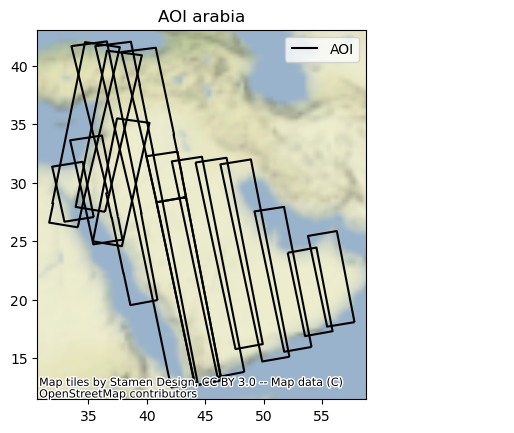

In [100]:
# Find all geojson config files
aoi_geojson_list = list(aoi_dir.glob('*.geojson'))

#################################
# load all json and plot tracks extent
for i, json in enumerate (aoi_geojson_list):
    if i==0:
        df_aoi= gpd.read_file(json)
    else:
        df_aoi = pd.concat([df_aoi, gpd.read_file(json)], axis=0, ignore_index=True)

print('List of tracks covering AOI: ', sorted(list(df_aoi.path_number)))

#AOI bounds extended for 1deg
aoi_bounds = np.array(df_aoi.unary_union.bounds) + np.array([-1, -1, 1, 1])
print('AOI bounds ', aoi_bounds)

#Plot AOI
fig, ax = plt.subplots()
df_aoi.exterior.plot(color='black', ax=ax, label='AOI')
cx.add_basemap(ax, zoom=2, source=cx.providers.Stamen.Terrain, crs=df_aoi.crs)
ax.set_xlim([aoi_bounds[0], aoi_bounds[2]])
ax.set_ylim([aoi_bounds[1], aoi_bounds[3]])
ax.set_title('AOI ' + df_aoi.aoi_name[0])
plt.legend()

In [102]:
df_aoi.loc[[8]]

aoi_name  path_number  min_days_backward  month_range_lower  \
8  ArabiaN           43                  0                  1   

   month_range_upper  num_neighbors  azimuth_mismatch deploy_url  \
8                 12              1               NaN        NaN   

  min_days_backward_timesubset num_neighbors_timesubset job_name  \
8                          NaN                      NaN      NaN   

                                            geometry  pathNumber update_AO  \
8  POLYGON Z ((40.83436 28.31527 0.00000, 43.3514...         NaN       NaN   

   temporal_window_days_timesubset  
8                              NaN

## Select the track for deployment

In [3]:
TRACK = 43

DEPLOY_URL = 'https://hyp3-nisar-jpl.asf.alaska.edu' #for access

In [103]:
##
deploy_df = df_aoi[df_aoi.path_number == TRACK]
deploy_df = df_aoi.loc[[8]]
deploy_df

track_filename = aoi_geojson_list[deploy_df.index[0]]

In [104]:
deploy_df

aoi_name  path_number  min_days_backward  month_range_lower  \
8  ArabiaN           43                  0                  1   

   month_range_upper  num_neighbors  azimuth_mismatch deploy_url  \
8                 12              1               NaN        NaN   

  min_days_backward_timesubset num_neighbors_timesubset job_name  \
8                          NaN                      NaN      NaN   

                                            geometry  pathNumber update_AO  \
8  POLYGON Z ((40.83436 28.31527 0.00000, 43.3514...         NaN       NaN   

   temporal_window_days_timesubset  
8                              NaN

In [105]:
track_filename

PosixPath('../../Arabia/aois/ArabiaN_pathNumber43.geojson')

# Parameters

This is what the operator is going to have to change. Will provide some comments.

In [106]:
params = {
    # Override metadata keys
    'update_AO' : True,
    ##### PRE-SELECTION ########
    # The merged SLC area over the AOI can be smaller by 
    # 'azimuth_mismatch' x swath width (i.e. 250km)
    'azimuth_mismatch' : 2,
    # For annual IFGs, select a single months of interest
    'month_range_lower' : 1, 
    'month_range_upper' : 12,
    
     ##### SEQUENTIAL PAIRS ########
    'num_neighbors' : 2, 
    # set temporal parameters, threshold to skip short temporal baselines 
    # (e.g 20, skip all pairs that have tbase < 20 days)
    'min_days_backward' : 0,
    
    ##### PERIODIC PAIRS (OPTIONAL) ########
    # temporal window to all temporal sampling intervals
    'temporal_window_days_timesubset' : 60,
    # Specify as many temporal sampling intervals as desired 
    # (e.g. 90 (days), 180 (days) = semiannual, 365 (days) = annual, etc.)
    'min_days_backward_timesubset' : [365],
    # Specify corresponding nearest neighbor sampling 
    # for each temporal sampling interval (by default (n-1))
    'num_neighbors_timesubset' : [1],
    #'job_name': [],
}

deploy_df = update_geojson(track_filename, params)
print('##########################')

today = datetime.datetime.now()
# Earliest year for reference frames
START_YEAR = 2014
# Latest year for reference frames
END_YEAR = today.year
YEARS_OF_INTEREST = list(range(START_YEAR,END_YEAR+1))
MONTHS_OF_INTEREST = list(range(params['month_range_lower'],
                                params['month_range_upper']+1))
print('YEARS: ',YEARS_OF_INTEREST)
print('MONTHS: ',MONTHS_OF_INTEREST)

print('##########################')

Read ../../Arabia/aois/ArabiaN_pathNumber43.geojson
Updating json: update_AO = True
Updating json: azimuth_mismatch = 2
Updating json: month_range_lower = 1
Updating json: month_range_upper = 12
Updating json: num_neighbors = 2
Updating json: min_days_backward = 0
Updating json: temporal_window_days_timesubset = 60
Updating json: min_days_backward_timesubset = [365]
Updating json: num_neighbors_timesubset = [1]
Geojson parameters:
  aoi_name : ArabiaN
  path_number : 43
  azimuth_mismatch : 2
  num_neighbors : 2
  month_range_lower : 1
  month_range_upper : 12
  min_days_backward_timesubset : 335
  temporal_window_days_timesubset : 60
  num_neighbors_timesubset : 1
  job_name : ArabiaN_43
Write ../../Arabia/aois/ArabiaN_pathNumber43.geojson
##########################
YEARS:  [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
MONTHS:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
##########################


In [107]:
deploy_df

aoi_name  path_number  min_days_backward  month_range_lower  \
0  ArabiaN           43                  0                  1   

   month_range_upper  num_neighbors    job_name  pathNumber  update_AO  \
0                 12              2  ArabiaN_43          43       True   

   azimuth_mismatch  temporal_window_days_timesubset  \
0                 2                               60   

  min_days_backward_timesubset num_neighbors_timesubset  \
0                          335                        1   

                                            geometry  
0  POLYGON Z ((40.83436 28.31527 0.00000, 43.3514...

T43, AOI Area 111052.28080229697 km2


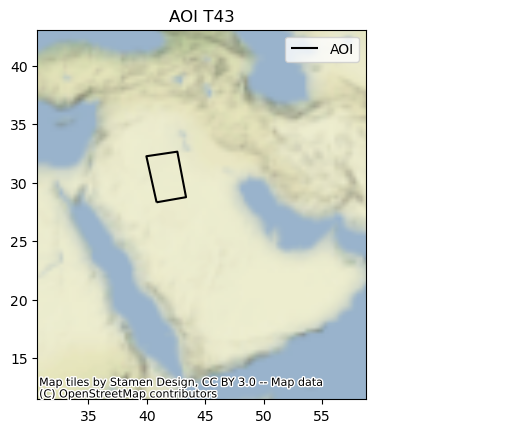

In [108]:
# Plot Track coverage
fig, ax = plt.subplots()
deploy_df.exterior.plot(color='black', ax=ax, label='AOI')
cx.add_basemap(ax, zoom=2, source=cx.providers.Stamen.Terrain, crs=deploy_df.crs)
ax.set_xlim([aoi_bounds[0], aoi_bounds[2]])
ax.set_ylim([aoi_bounds[1], aoi_bounds[3]])
ax.set_title(f'AOI T{deploy_df.path_number[0]}')
plt.legend()

track_area_coverage = shapefile_area(deploy_df.unary_union)

print(f'T{deploy_df.path_number[0]}, AOI Area', track_area_coverage,'km2')

(print('\033[1m',f'Consider splitting track AOI to multi-segments, track area {track_area_coverage:.2f} > 200000 km2','\033[0m') 
 if track_area_coverage > 200000 else None)

Split AOI at:  30.00 lat
Split line: LINESTRING (38.96195650449497 30, 44.35149409608715 30.335053839408626)

         minx       miny       maxx       maxy
0  40.440820  28.315270  43.351494  30.255049
1  39.961957  30.091937  43.064567  32.645162 

Segment 0 area: 46432.32 km2
Segment 1 area: 64660.63 km2


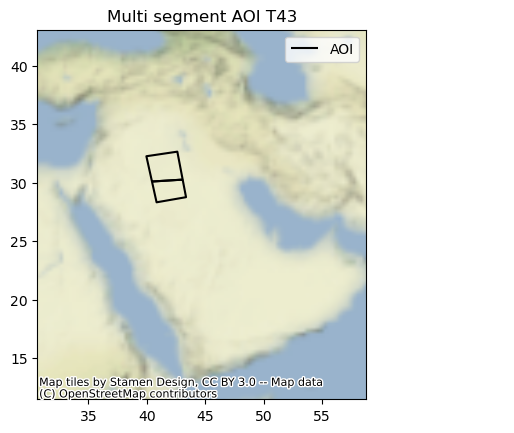

In [113]:
lats_for_splitting_aoi = [30]
#lats_for_splitting_aoi = [18, 24, 30, 39]

########################################################
##############  SPLIT TRACK AOI ########################

aois_geometry = split_aoi(deploy_df, lats_for_splitting_aoi)
aois_geometry['azimuth_mismatch'] = 5
print('\n', aois_geometry.bounds, '\n')

fig, ax = plt.subplots()
aois_geometry.exterior.plot(color='black', ax=ax, label='AOI')
cx.add_basemap(ax, zoom=2, source=cx.providers.Stamen.Terrain, crs=aois_geometry.crs)
ax.set_xlim([aoi_bounds[0], aoi_bounds[2]])
ax.set_ylim([aoi_bounds[1], aoi_bounds[3]])
ax.set_title(f'Multi segment AOI T{deploy_df.path_number[0]}')
plt.legend()

segment_list = [gpd.GeoDataFrame(segment_df).T for i, segment_df in aois_geometry.iterrows()]

for i, segment_df in enumerate(segment_list):
    print(f'Segment {i} area: {shapefile_area(segment_df.unary_union):.2f} km2') 

# Generate a stack

Using all the tiles that are needed to cover the AOI we make a geometric query based on the frame. We now include only the path we are interested in.

In [114]:
from s1_enumerator import get_s1_stack_by_dataframe

stack_list = []

for i, aoi_geometry in aois_geometry.iterrows():
    segment_df = gpd.GeoDataFrame(aoi_geometry).T
    
    stack_list.append(get_s1_stack_by_dataframe(segment_df,
                                                path_numbers=segment_df.pathNumber.to_list()))
    
df_stack = pd.concat(stack_list, axis=0)

f'We have {df_stack.shape[0]} frames in our stack'

'We have 1474 frames in our stack'

In [116]:
######## PRINT INFO
print('\033[1m' + "Stack information", '\033[0m')
print("Track: ", aois_geometry.pathNumber.unique()[0])
print("Orbit: ", df_stack.flightDirection.unique()[0])
print("Start Date: ", df_stack.start_date.min())
print("End Date: ", df_stack.start_date.max())
print("Frames #: ", sorted(df_stack.frameNumber.unique()))

Stack information 
Track:  43
Orbit:  ASCENDING
Start Date:  2014-10-08 00:00:00
End Date:  2022-10-02 00:00:00
Frames #:  [87, 88, 89, 90, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 106]


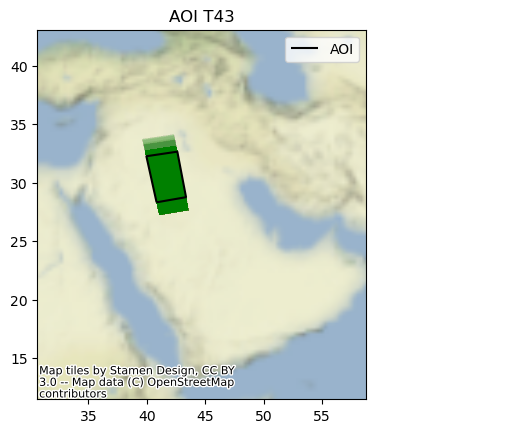

In [117]:
# Plot stack
fig, ax = plt.subplots()
df_stack.plot(ax=ax, alpha=.01, color='green')
deploy_df.exterior.plot(color='black', ax=ax, label='AOI')
cx.add_basemap(ax, zoom=2, source=cx.providers.Stamen.Terrain, crs=deploy_df.crs)
ax.set_xlim([aoi_bounds[0], aoi_bounds[2]])
ax.set_ylim([aoi_bounds[1], aoi_bounds[3]])
ax.set_title(f'AOI T{deploy_df.path_number[0]}')
plt.legend()

Note, we now see the frames cover the entire AOI as we expect.
First remove all scenes that do not produce spatiotemporally contiguous pairs and not meet specified intersection threshold

In [118]:
azimuth_mismatch = 5
df_stack_new, overlap_metadata = minimum_overlap_query(df_stack, 
                                               deploy_df.geometry.unary_union, 
                                               azimuth_mismatch=azimuth_mismatch,
                                               print_msg=True)

0/1474 scenes rejected for not intersecting with the AOI
Gap for scene 273 

Gap for scene 281 

Gap for scene 289 

Gap for scene 297 

Gap for scene 305 

Gap for scene 313 

Gap for scene 321 

Gap for scene 329 

Gap for scene 337 

Gap for scene 345 

Gap for scene 353 

Gap for scene 361 

Gap for scene 369 

Gap for scene 377 

Gap for scene 385 

Gap for scene 393 

Gap for scene 401 

Gap for scene 409 

Gap for scene 417 

Gap for scene 425 

Gap for scene 433 

Gap for scene 441 

Gap for scene 449 

Gap for scene 457 

Gap for scene 465 

Gap for scene 473 

Gap for scene 481 

Gap for scene 489 

Gap for scene 497 

Gap for scene 505 

Gap for scene 513 

Gap for scene 521 

Gap for scene 529 

Gap for scene 537 

Gap for scene 545 

Gap for scene 553 

Gap for scene 561 

Gap for scene 569 

Gap for scene 577 

Gap for scene 585 

Gap for scene 593 

Gap for scene 601 

Gap for scene 609 

Gap for scene 617 

Gap for scene 625 

Gap for scene 633 

Gap for scene 641 

Gap

Rejected scene S1A_IW_SLC__1SDV_20150816T151548_20150816T151615_007290_009FEB_E358-SLC has only 65597km² overlap with AOI
Rejected scene S1A_IW_SLC__1SDV_20150828T151521_20150828T151550_007465_00A4AA_EA85-SLC has only 65601km² overlap with AOI
Rejected scene S1A_IW_SLC__1SDV_20150828T151521_20150828T151550_007465_00A4AA_EA85-SLC has only 65601km² overlap with AOI
Rejected scene S1A_IW_SLC__1SDV_20150828T151548_20150828T151615_007465_00A4AA_8554-SLC has only 65601km² overlap with AOI
Rejected scene S1A_IW_SLC__1SDV_20150909T151521_20150909T151551_007640_00A977_ABEC-SLC has only 65599km² overlap with AOI
Rejected scene S1A_IW_SLC__1SDV_20150909T151521_20150909T151551_007640_00A977_ABEC-SLC has only 65599km² overlap with AOI
Rejected scene S1A_IW_SLC__1SDV_20150909T151549_20150909T151616_007640_00A977_0209-SLC has only 65599km² overlap with AOI
Rejected scene S1A_IW_SLC__1SDV_20150921T151521_20150921T151551_007815_00AE11_5FD2-SLC has only 65571km² overlap with AOI
Rejected scene S1A_IW_SL

In [119]:
kept_ratio = len(df_stack_new)/len(df_stack)

print(f'Kept ratio: {round(kept_ratio*100)}%')
print(f'Azimuth mismatch: {azimuth_mismatch}')
print(f'We have {df_stack_new.shape[0]} frames in our stack')
print('##########################################')
print('aoi_coverage: ', overlap_metadata['aoi_coverage'], 'km2')
print('allow_area_miscoverage: ',overlap_metadata['allow_area_miscoverage'], 'km2')
print('min_ovlp_thresh: ',overlap_metadata['min_ovlp_thresh'],'km2')

Kept ratio: 48%
Azimuth mismatch: 5
We have 705 frames in our stack
##########################################
aoi_coverage:  111052.28080229697 km2
allow_area_miscoverage:  1250 km2
min_ovlp_thresh:  109802.28080229697 km2


/Users/govorcin/Projects/ACCESS/HyP3-ARIA-Orchestration/deployment_notebooks/deploytools/util.py:204: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


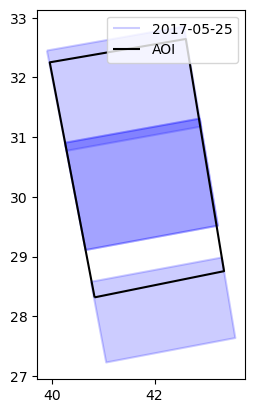

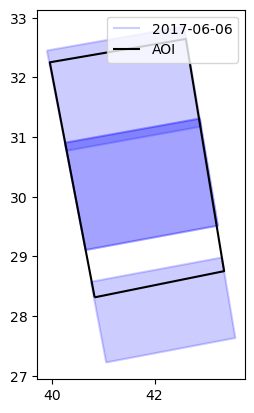

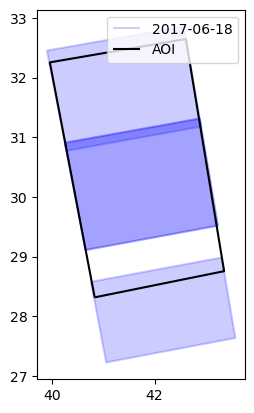

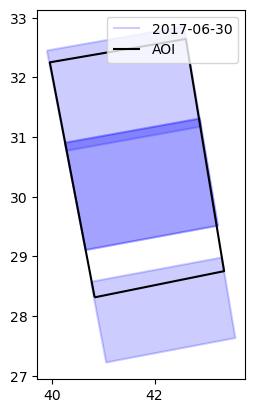

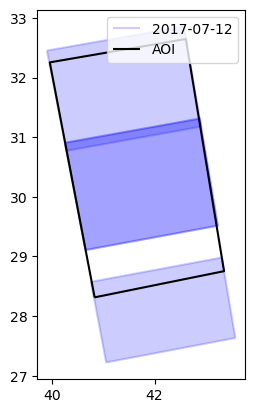

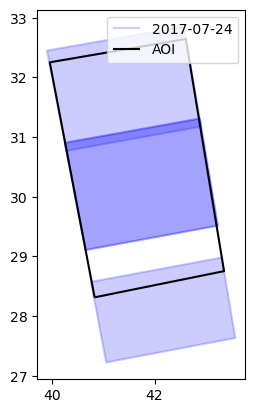

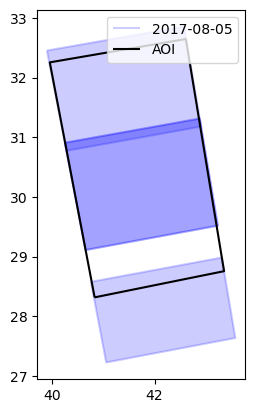

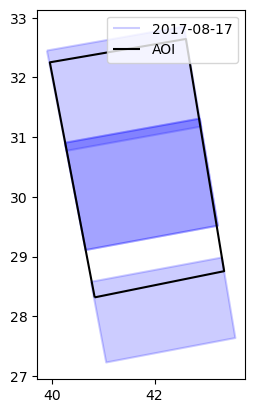

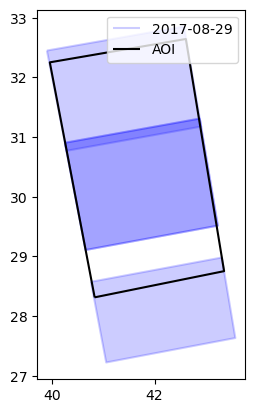

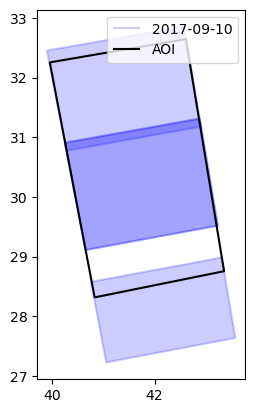

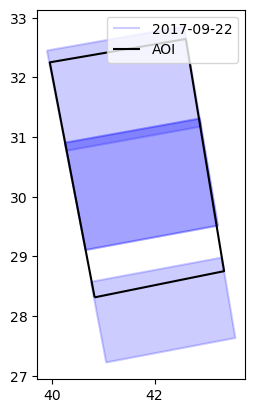

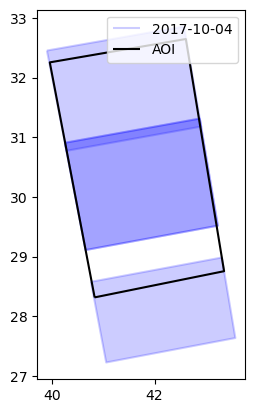

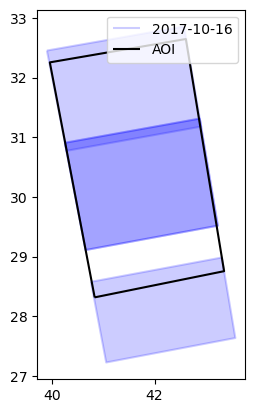

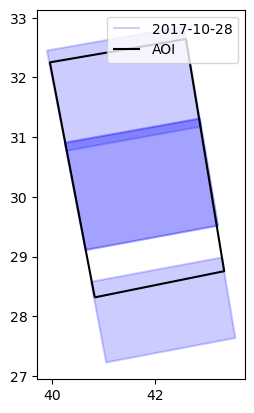

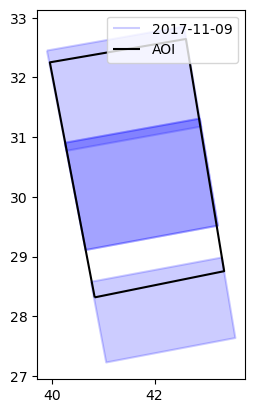

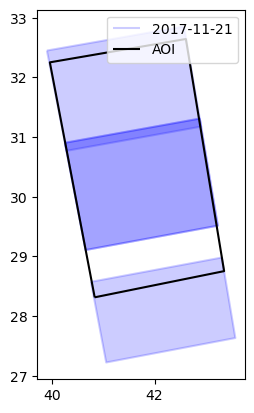

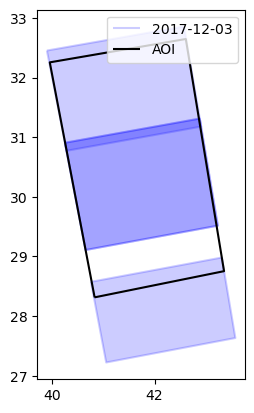

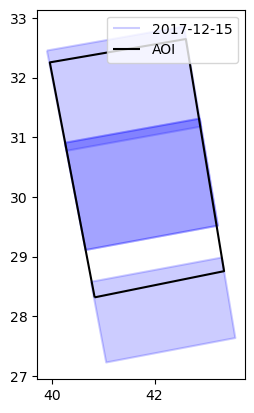

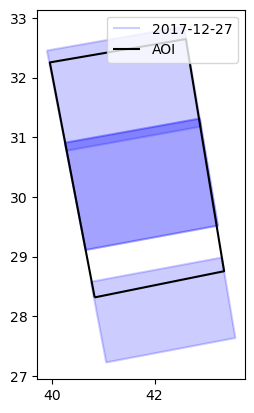

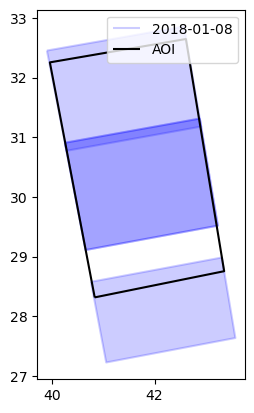

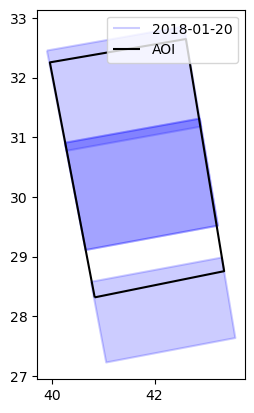

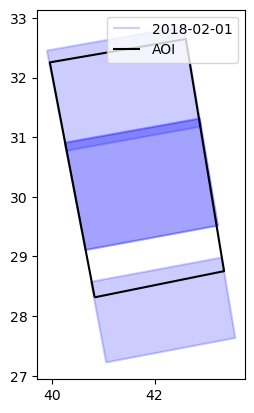

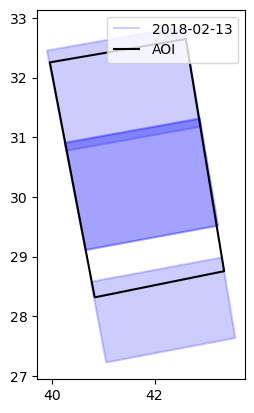

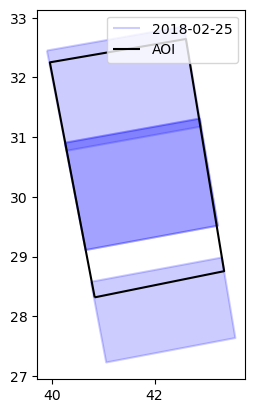

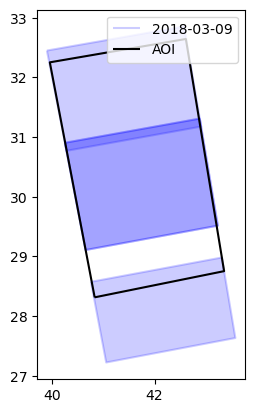

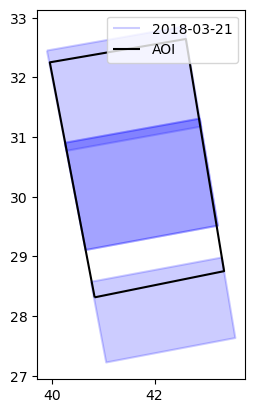

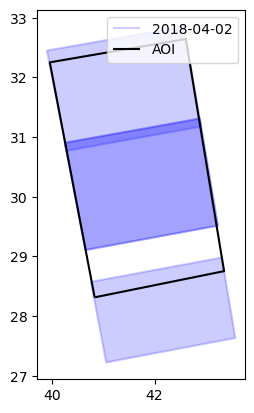

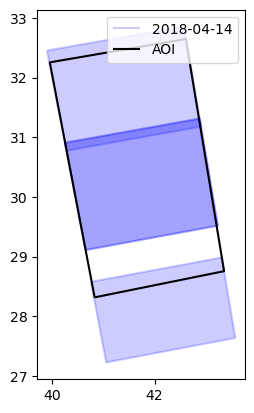

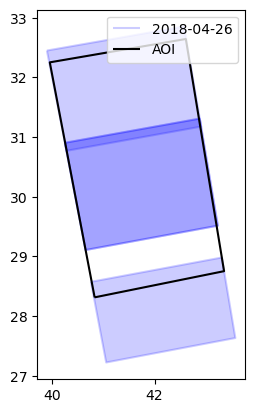

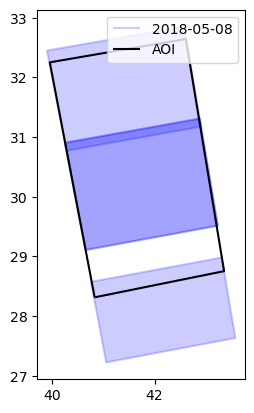

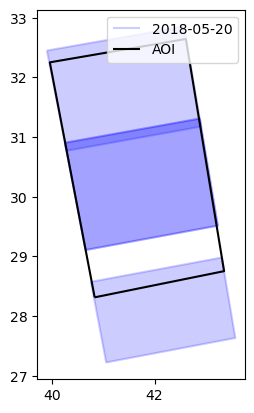

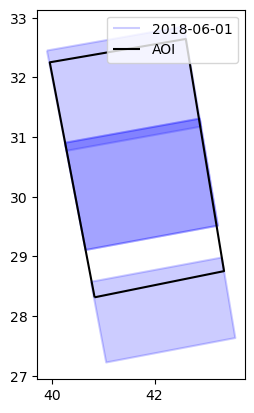

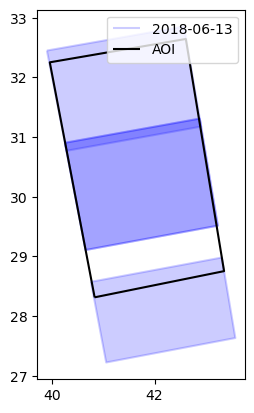

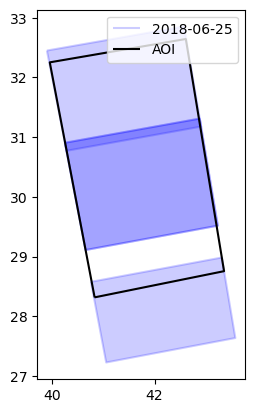

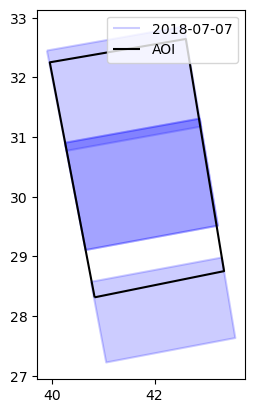

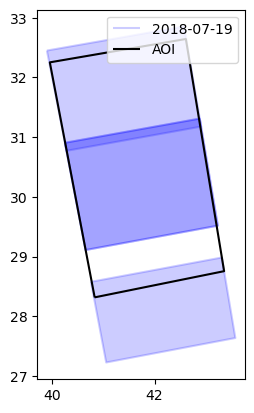

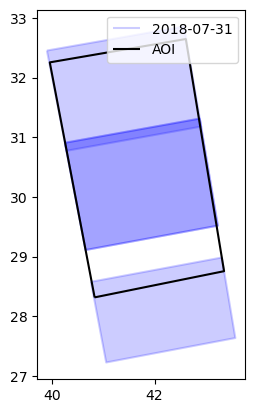

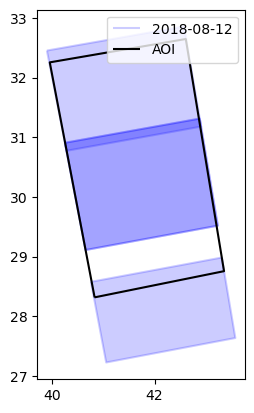

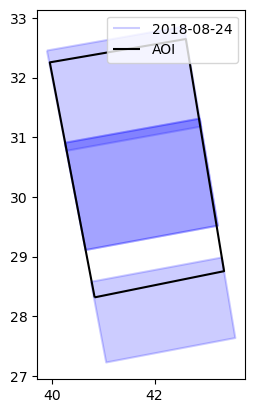

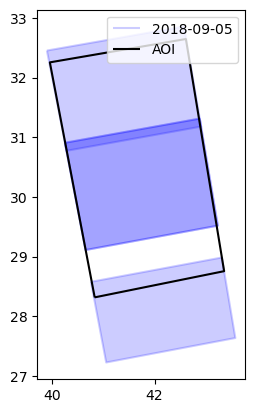

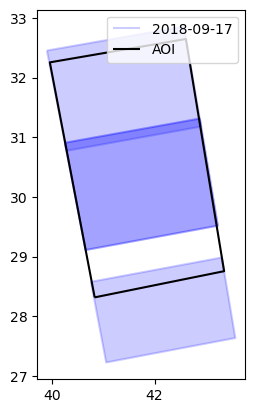

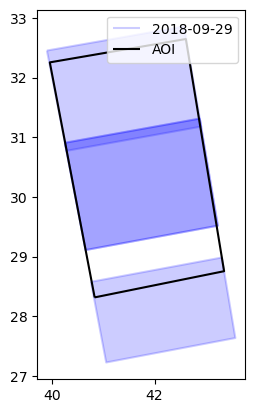

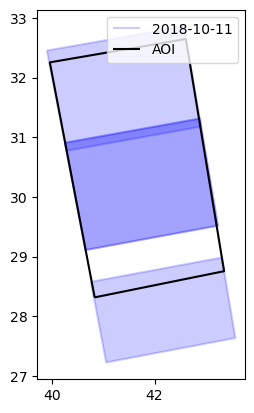

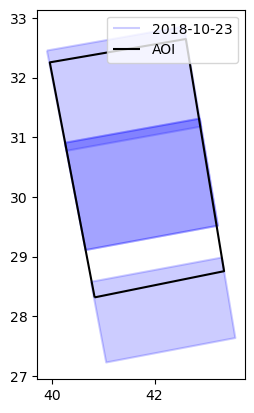

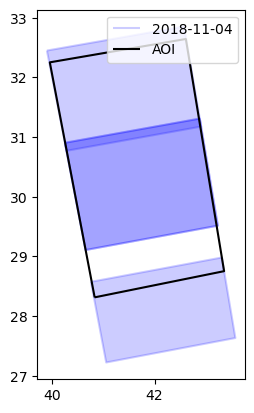

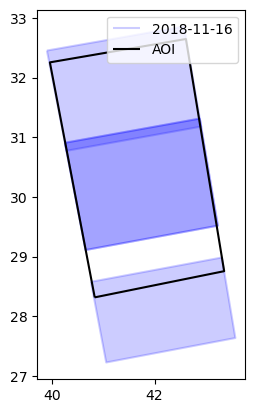

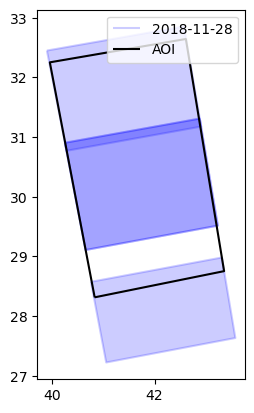

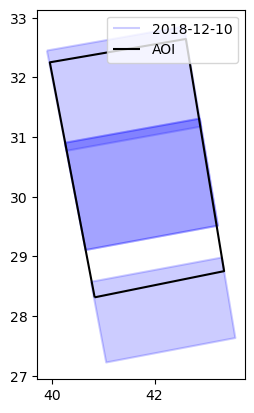

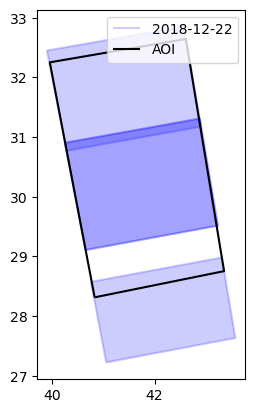

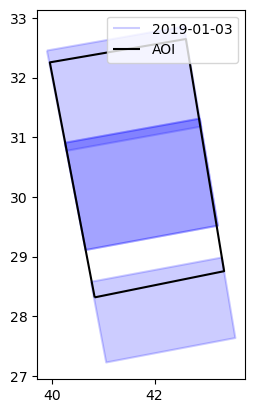

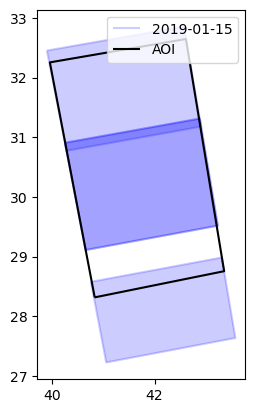

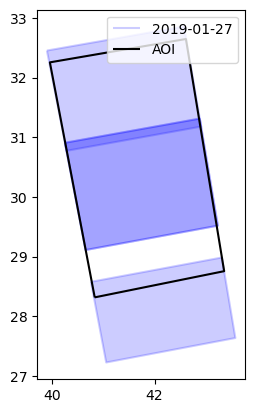

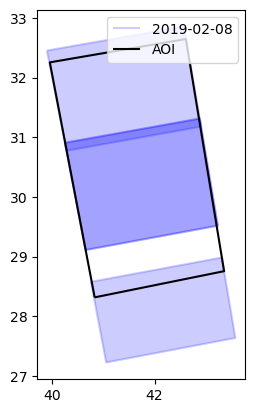

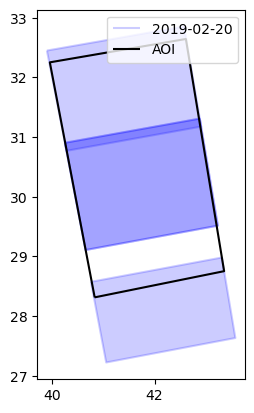

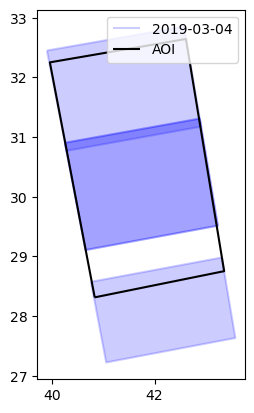

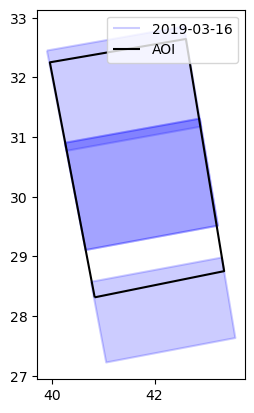

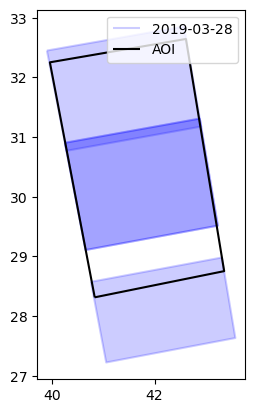

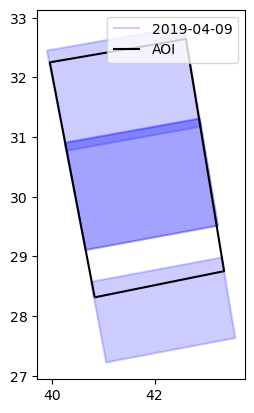

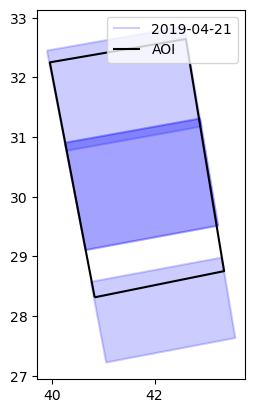

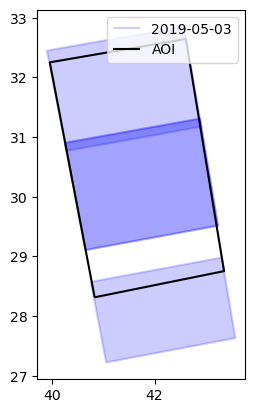

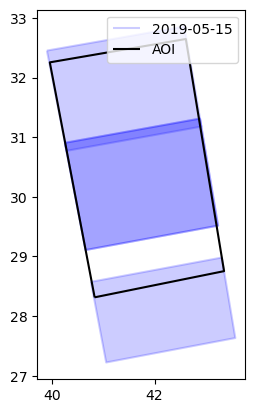

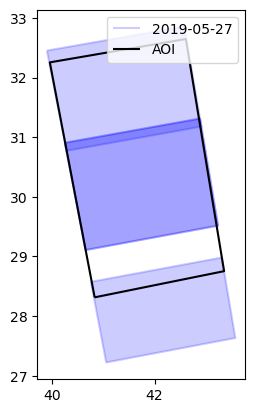

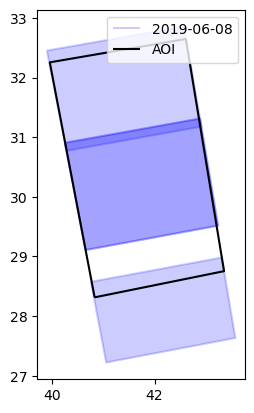

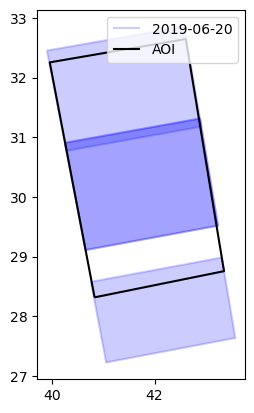

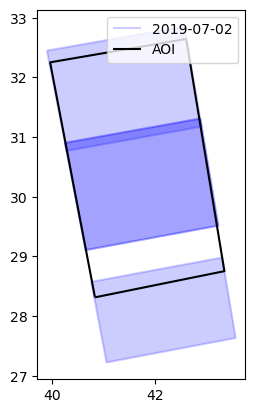

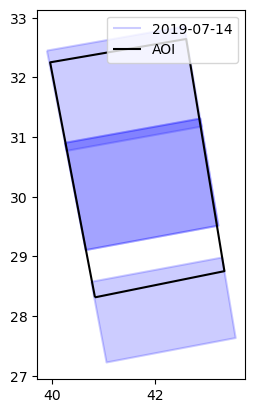

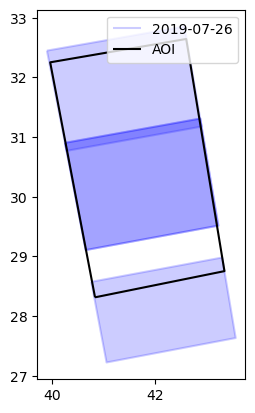

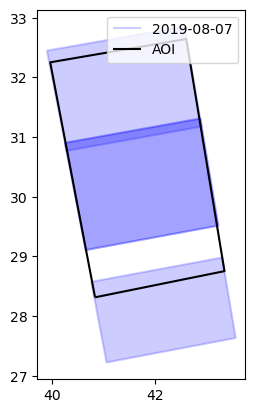

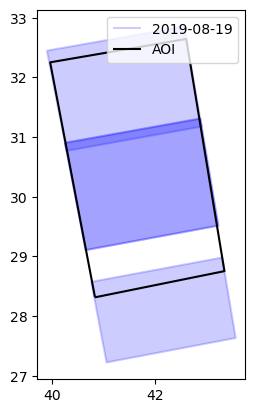

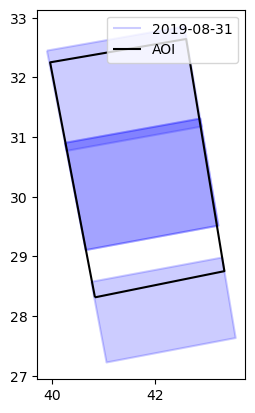

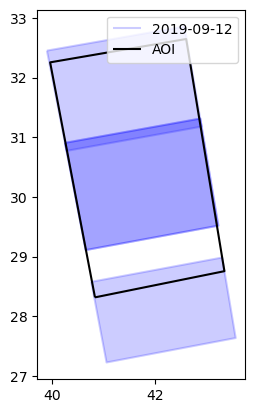

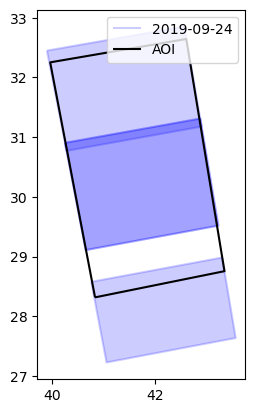

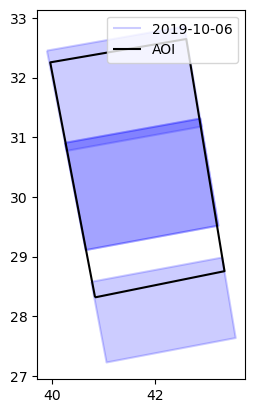

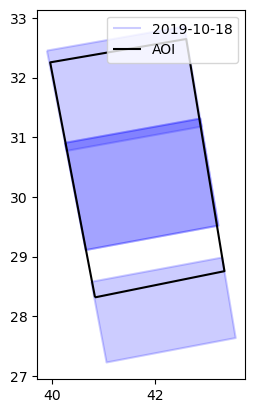

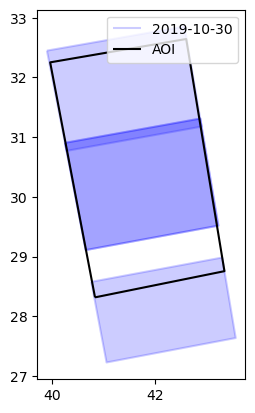

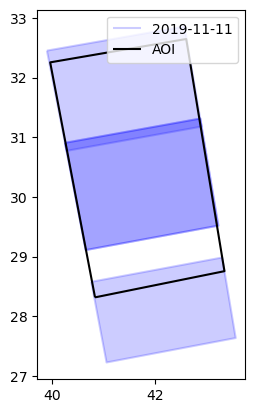

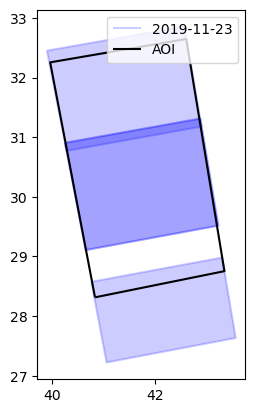

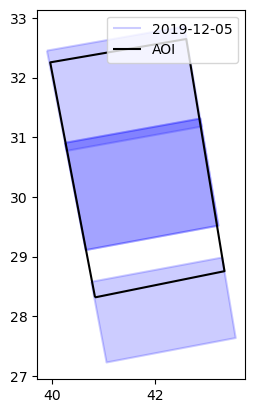

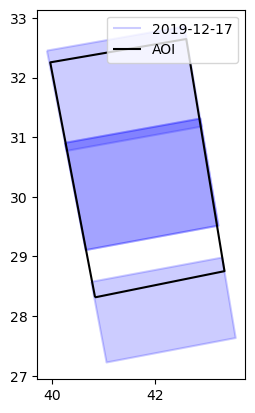

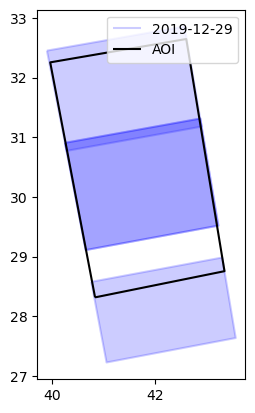

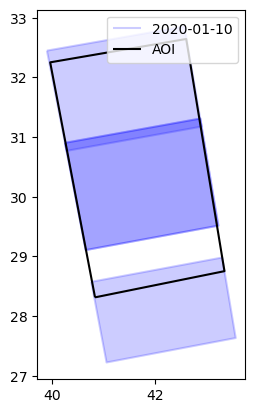

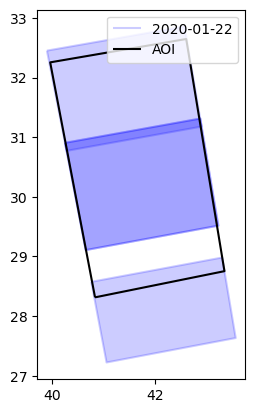

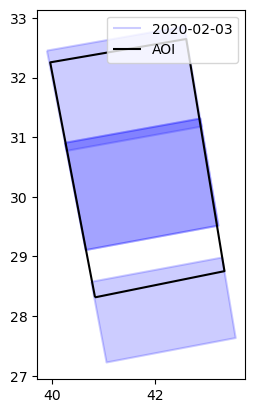

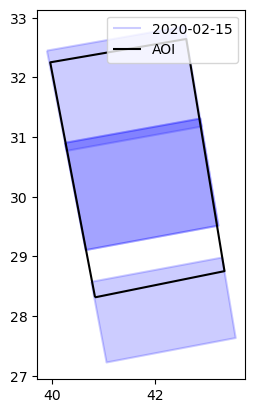

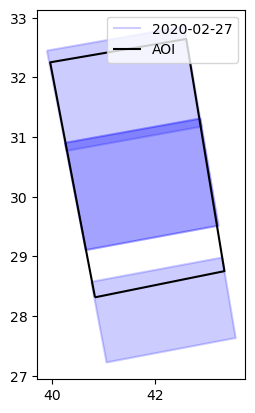

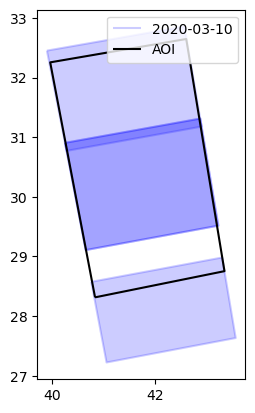

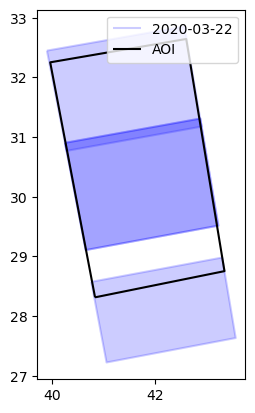

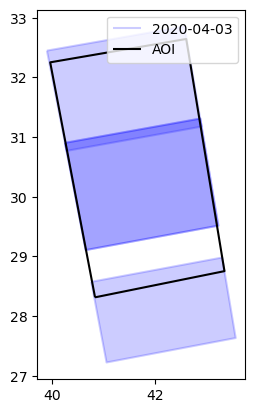

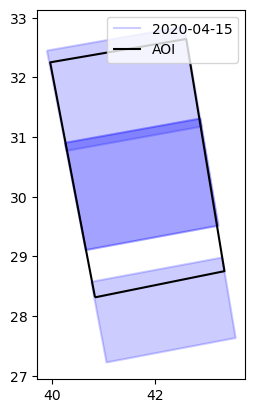

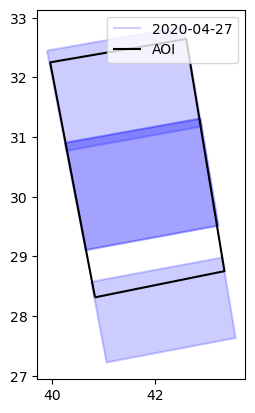

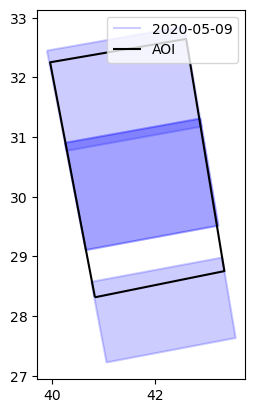

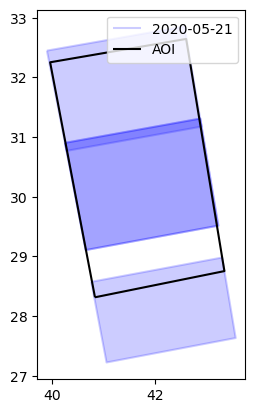

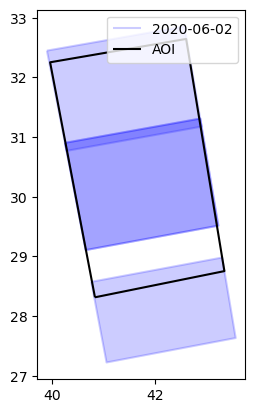

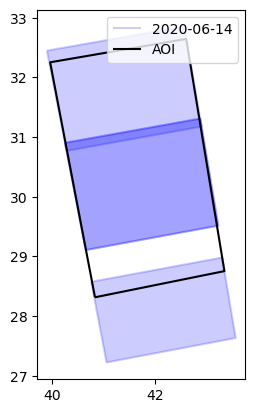

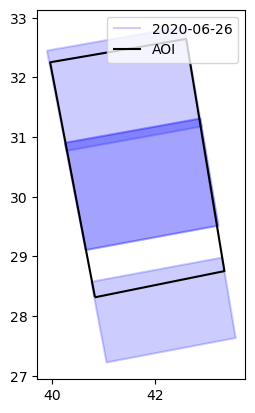

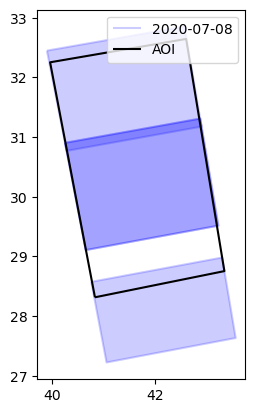

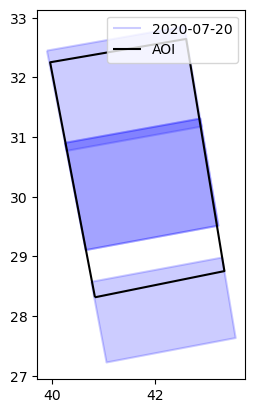

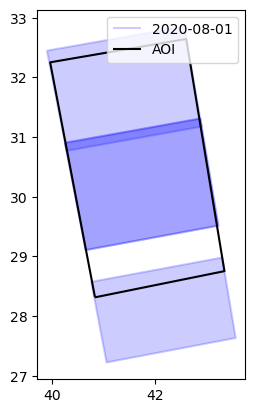

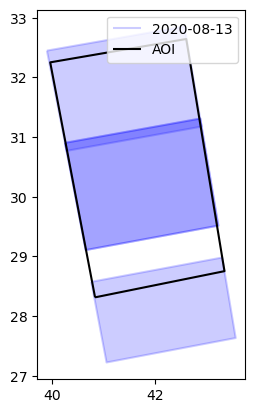

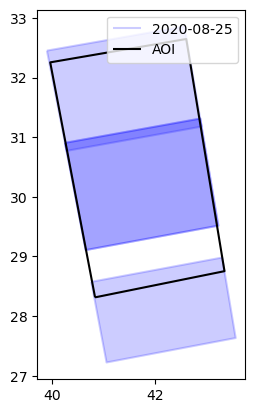

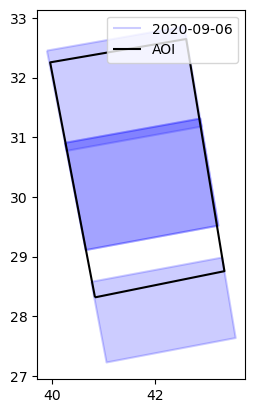

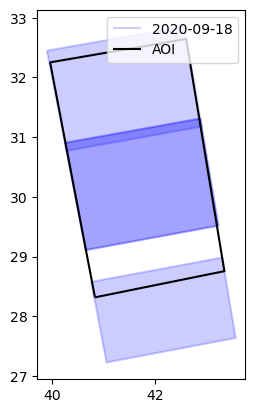

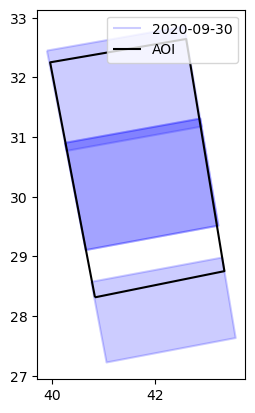

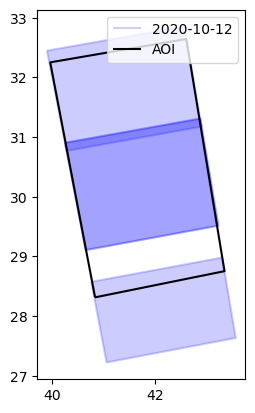

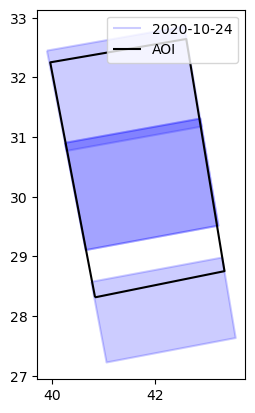

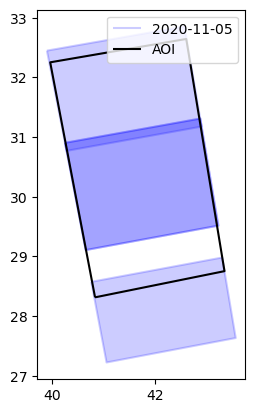

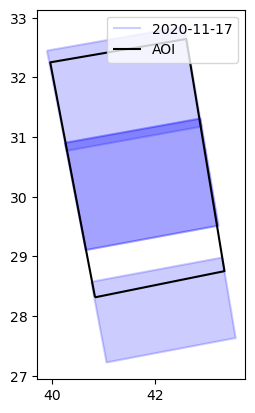

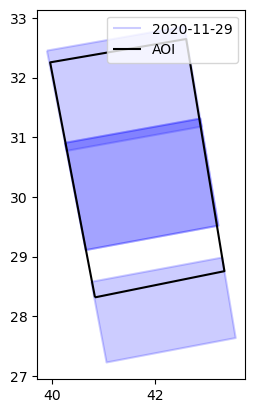

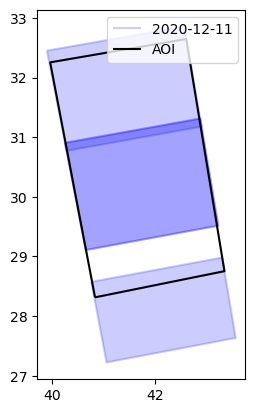

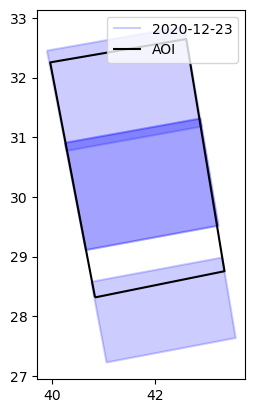

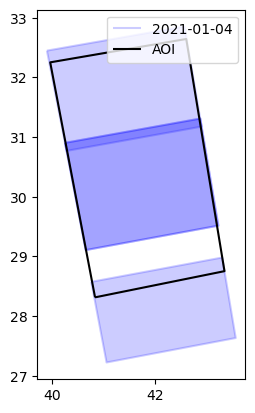

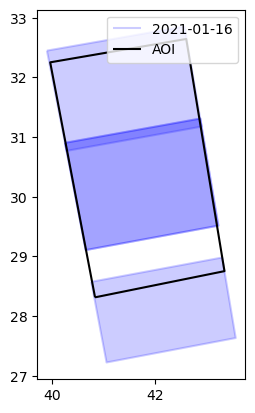

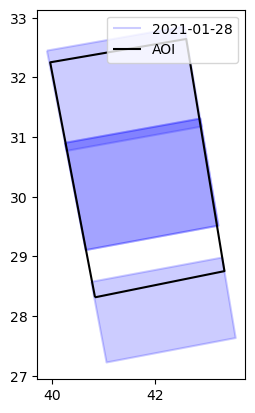

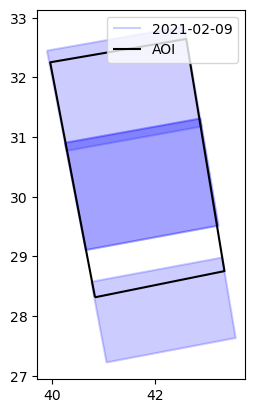

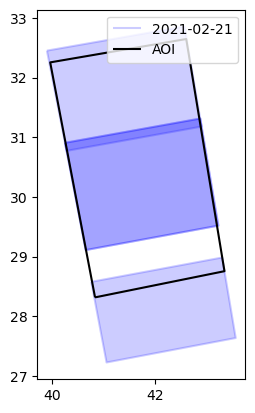

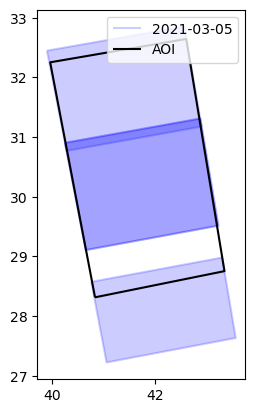

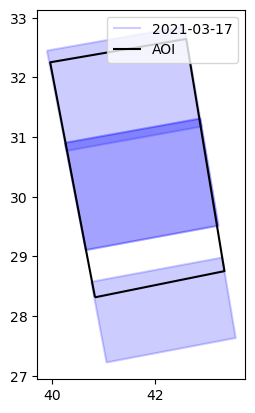

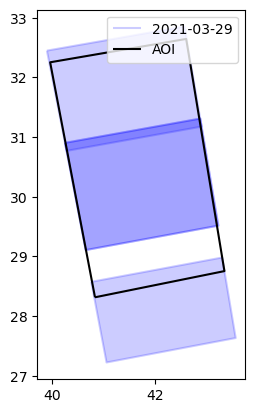

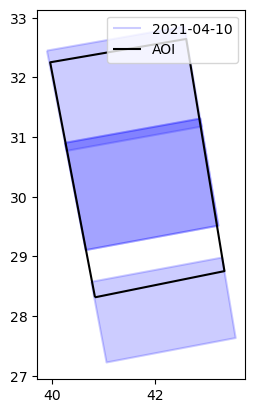

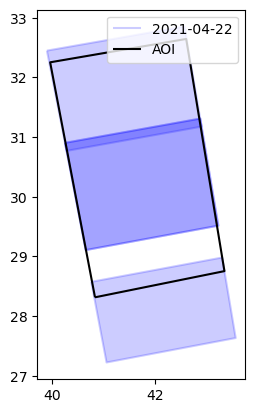

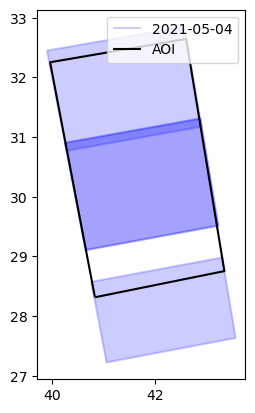

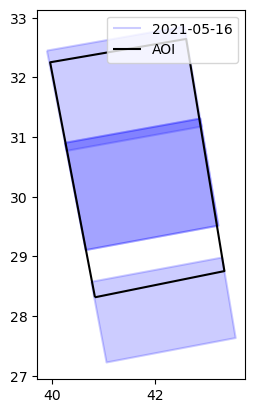

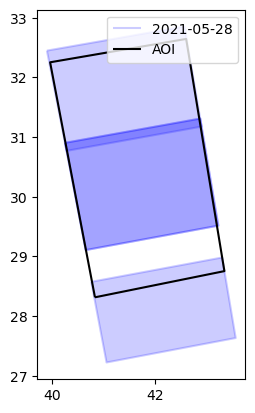

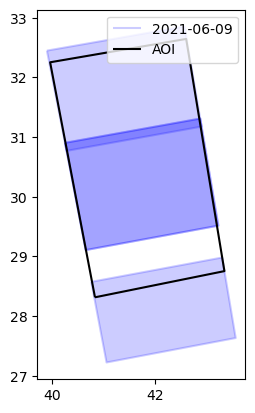

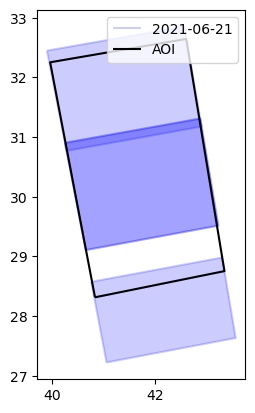

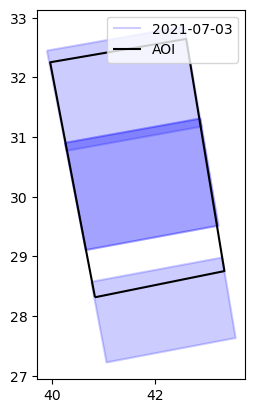

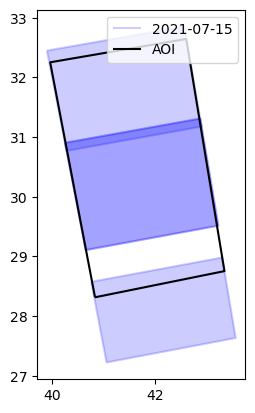

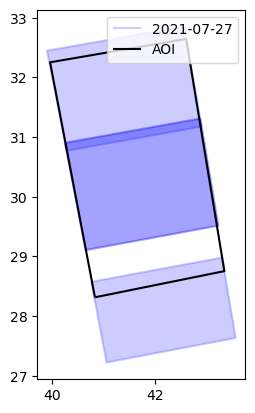

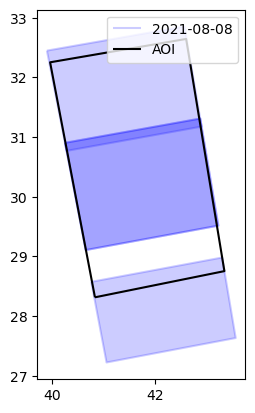

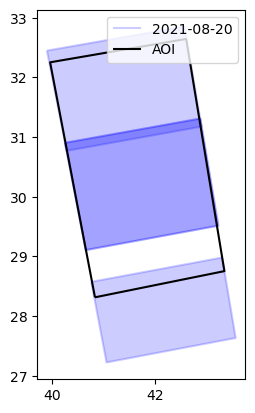

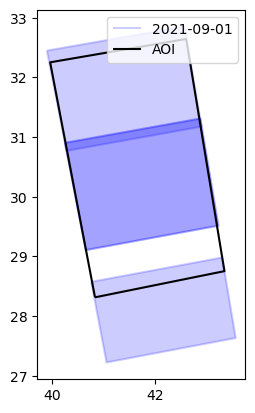

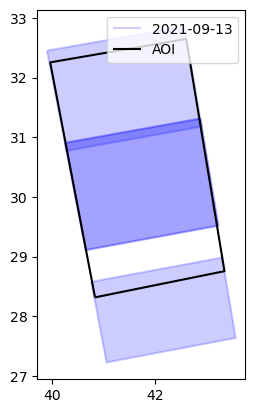

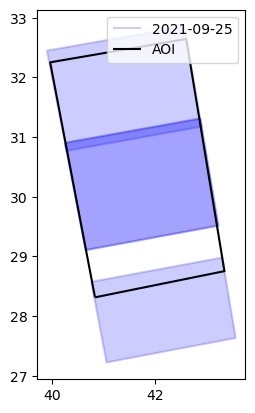

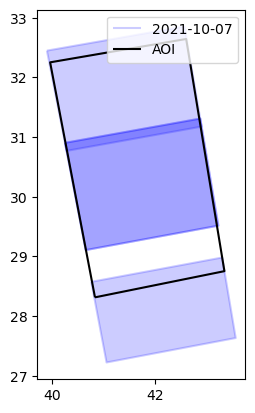

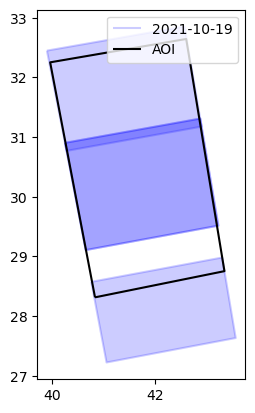

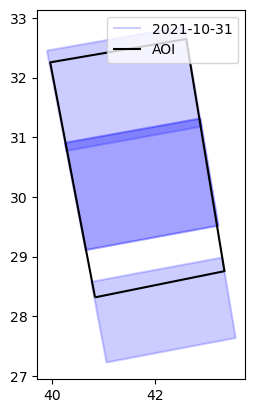

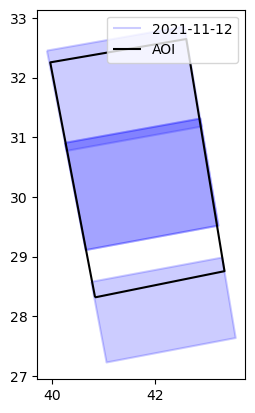

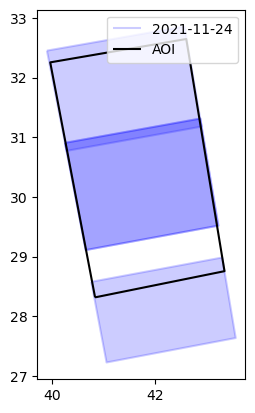

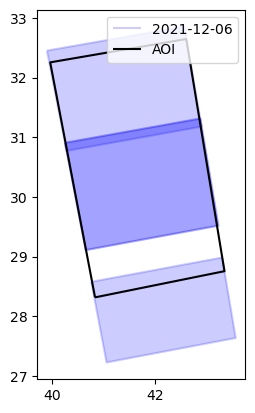

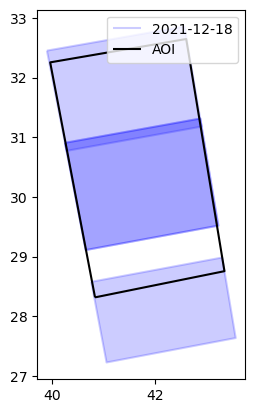

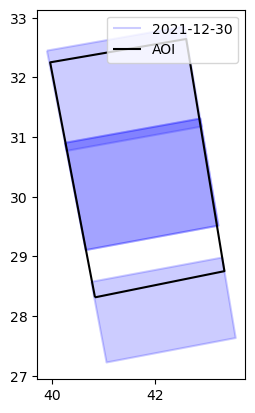

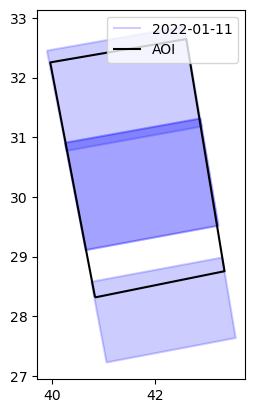

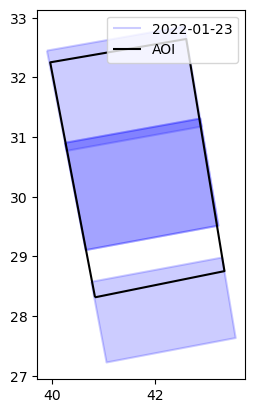

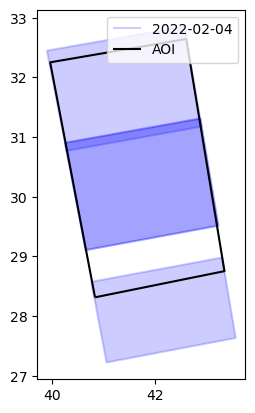

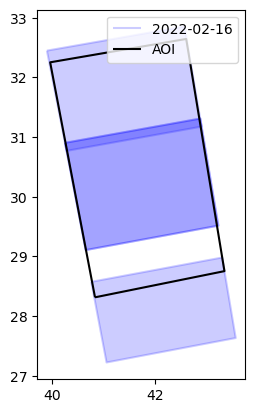

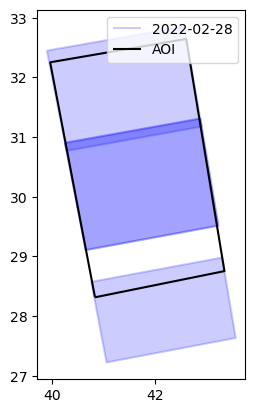

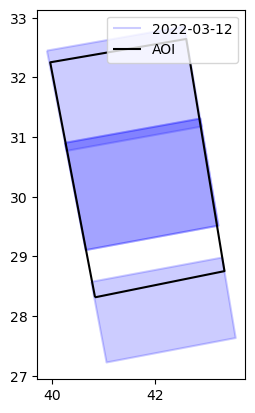

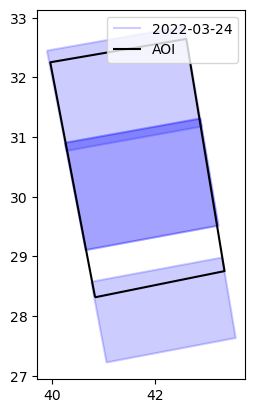

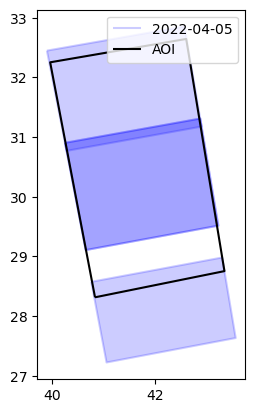

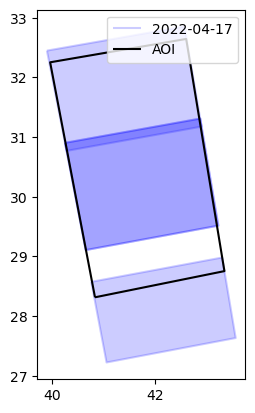

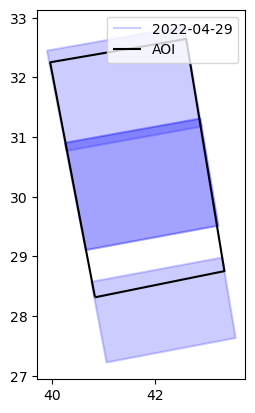

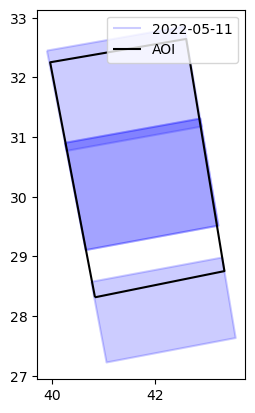

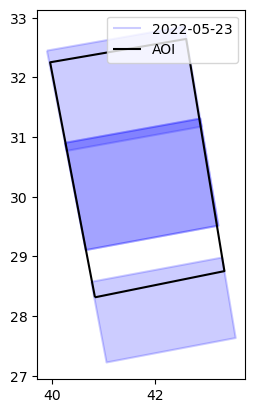

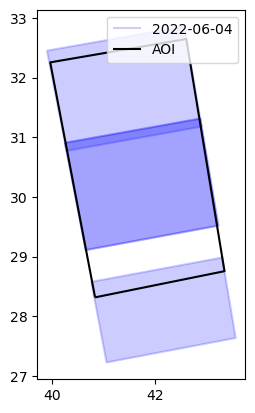

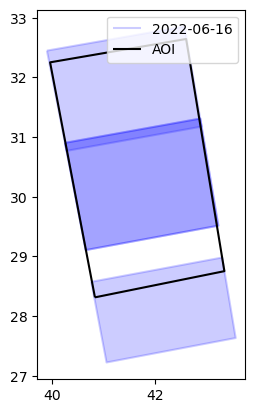

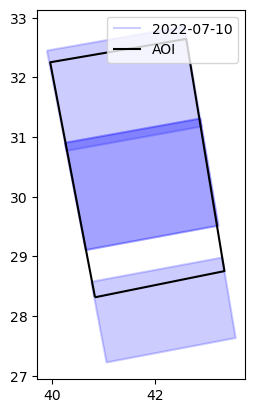

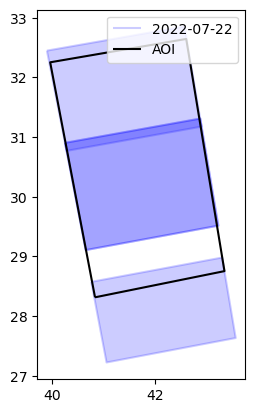

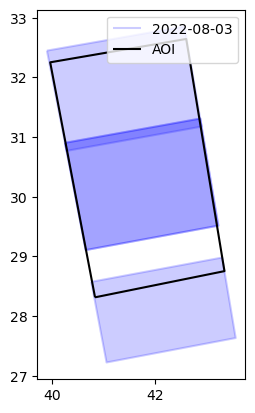

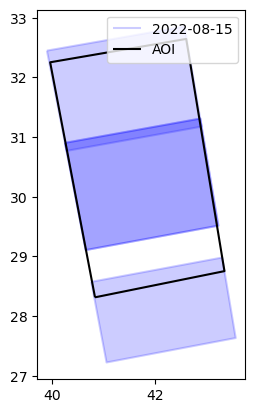

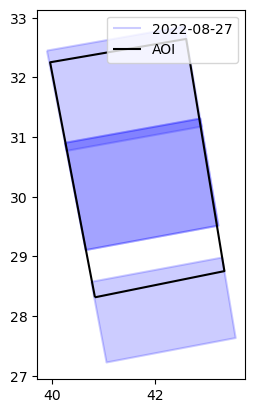

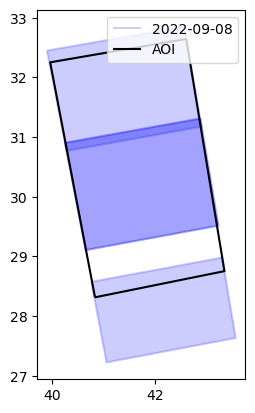

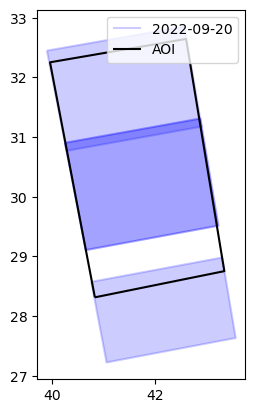

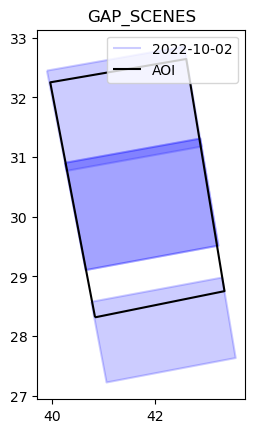

In [120]:
# Plot acquisitions that aren't continuous (i.e. have gaps)
overlap_debug_plots(deploy_df, overlap_metadata, 'gap_scenes')

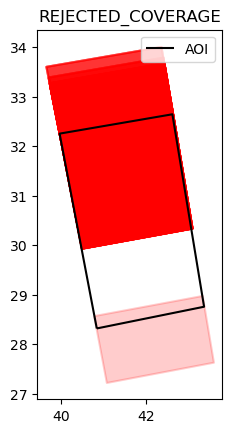

In [121]:
# Plot all individual mosaicked acquisitions that were rejected 
overlap_debug_plots(deploy_df, overlap_metadata, 'rejected_coverage')

/Users/govorcin/Projects/ACCESS/HyP3-ARIA-Orchestration/deployment_notebooks/deploytools/util.py:194: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


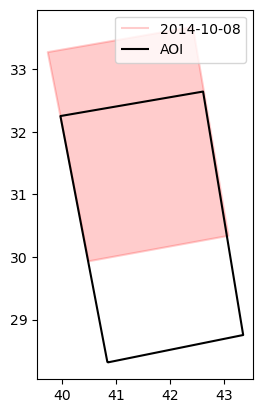

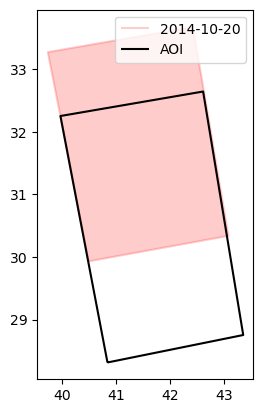

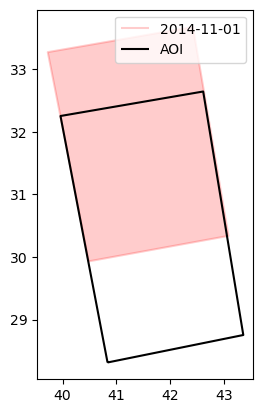

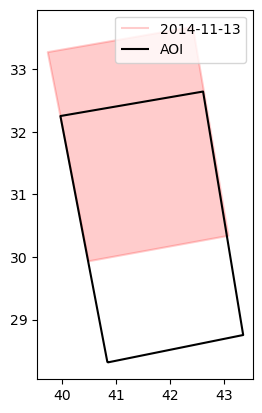

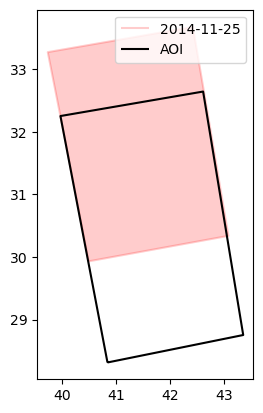

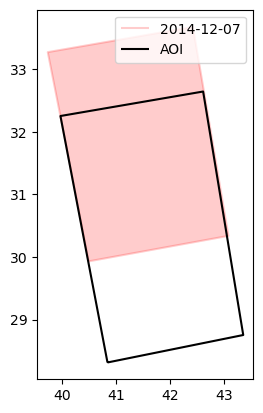

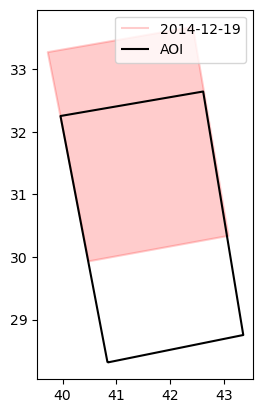

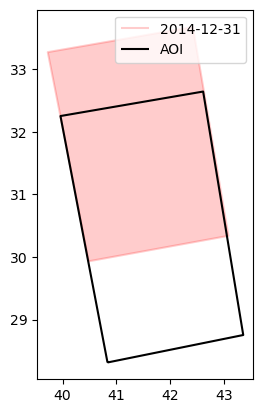

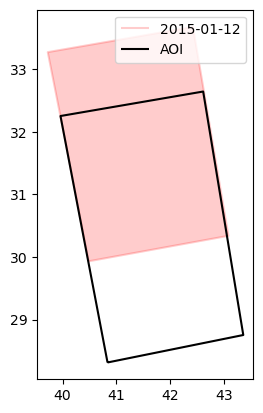

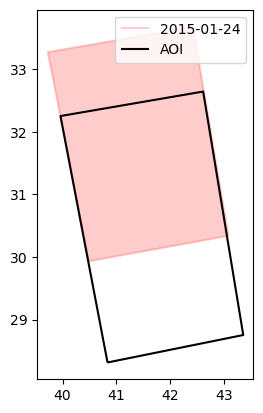

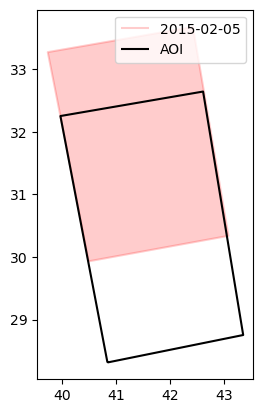

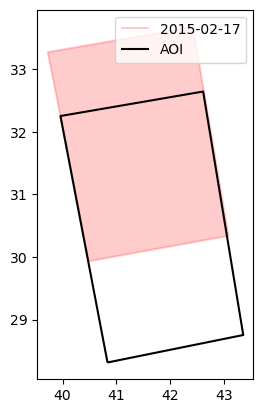

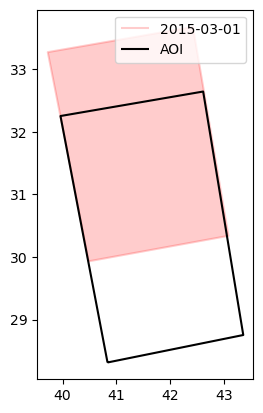

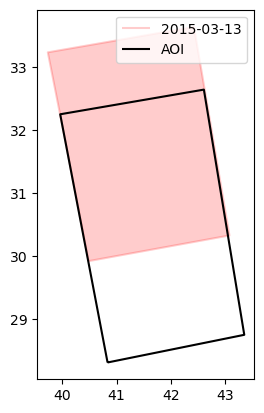

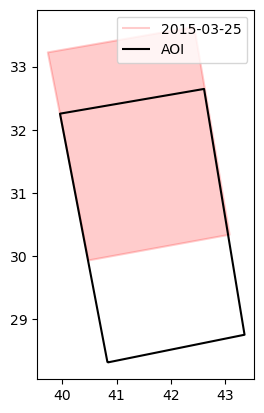

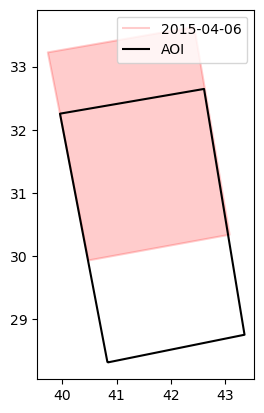

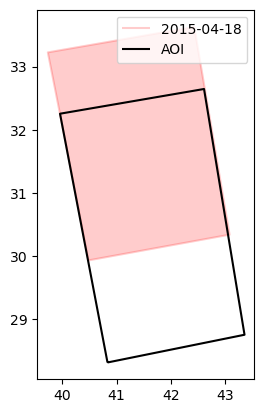

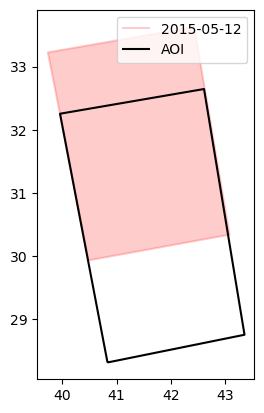

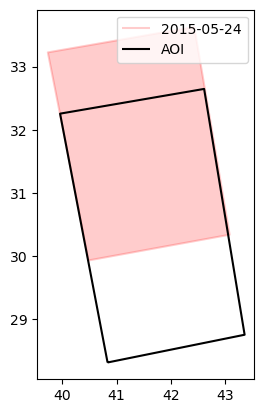

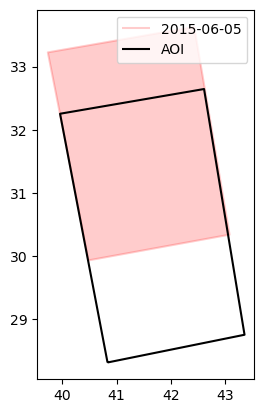

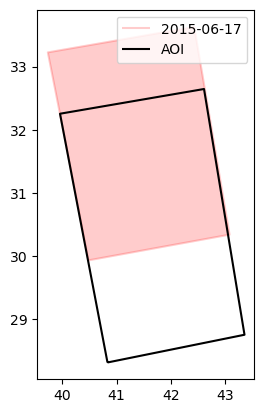

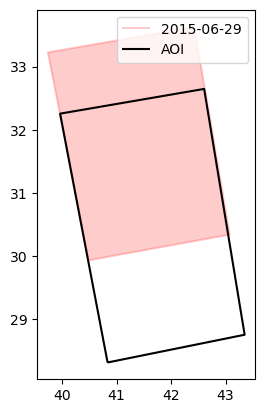

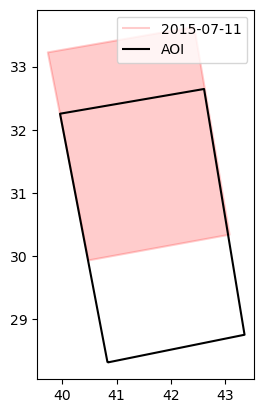

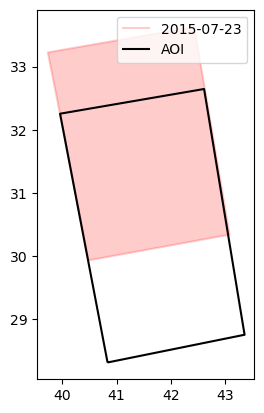

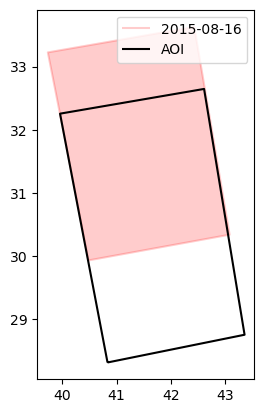

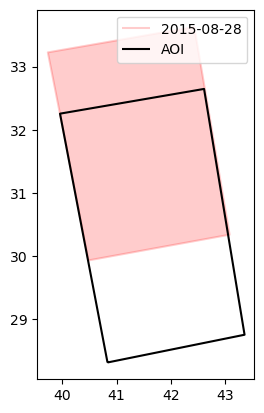

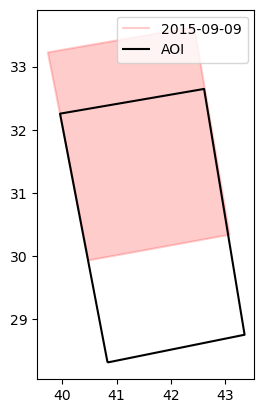

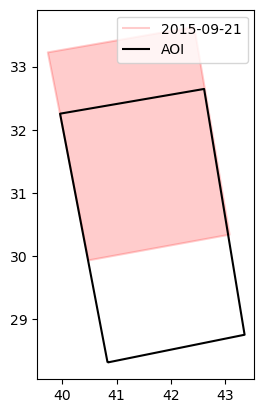

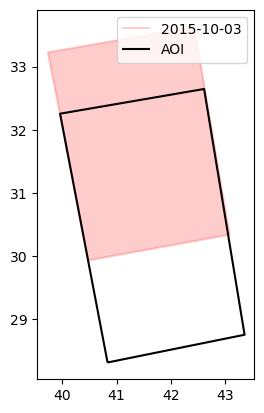

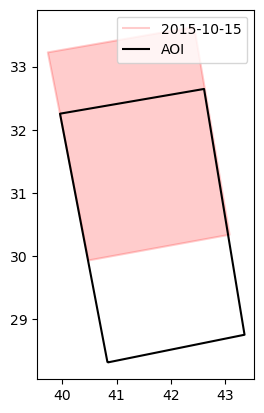

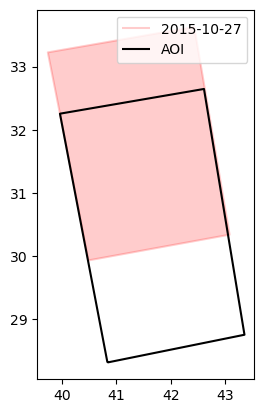

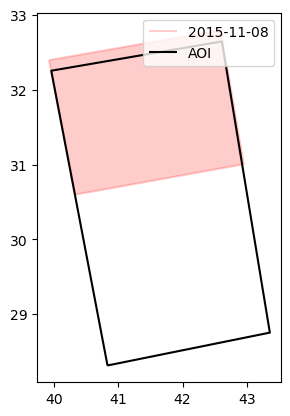

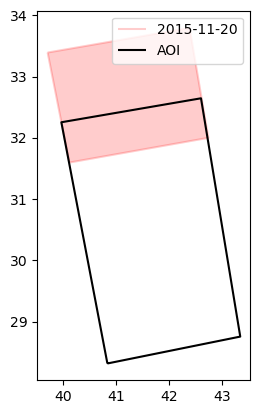

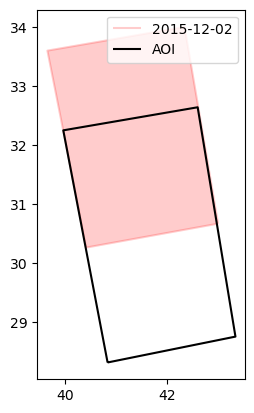

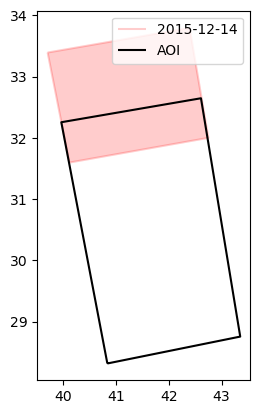

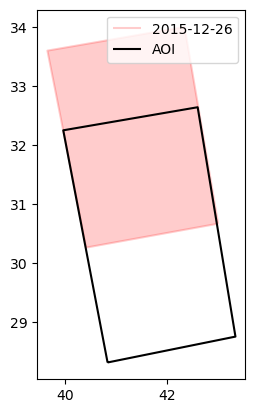

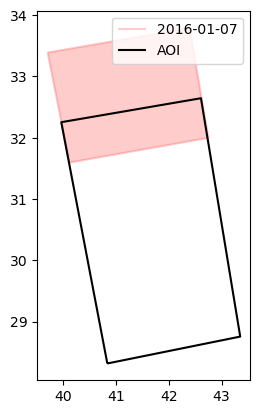

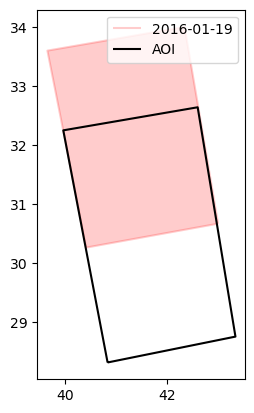

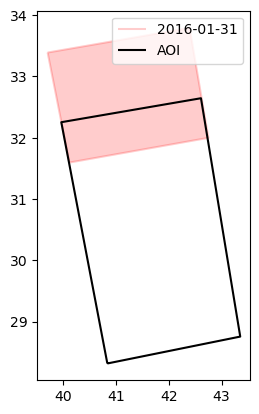

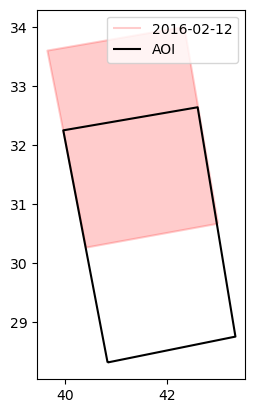

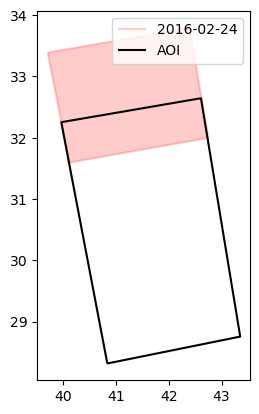

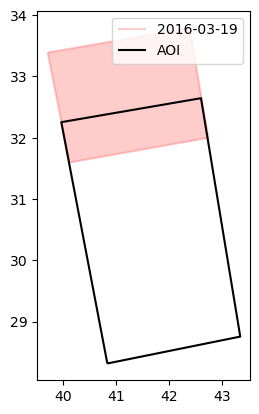

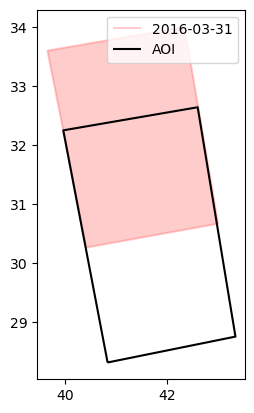

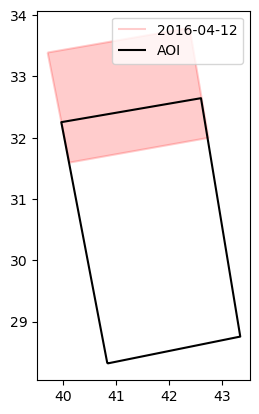

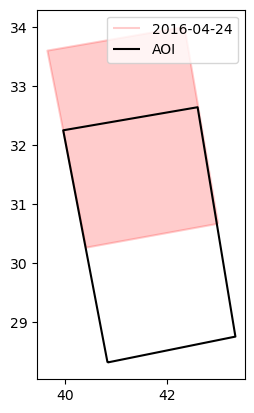

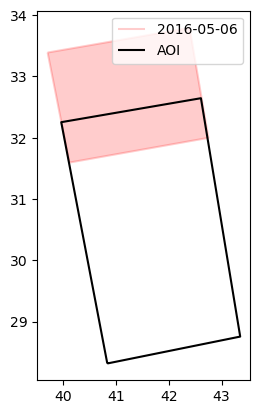

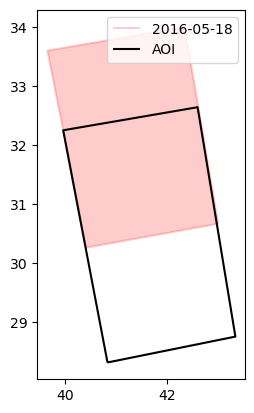

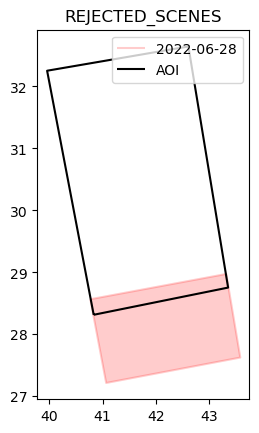

In [122]:
# Plot all individual mosaicked acquisitions that were rejected 
overlap_debug_plots(deploy_df, overlap_metadata, 'rejected_scenes')

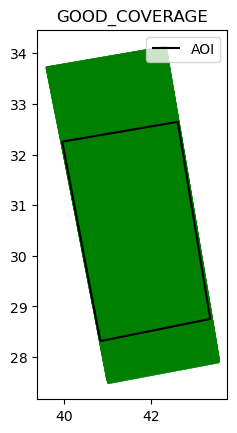

In [123]:
# Plot all mosaicked acquisitions that meet user-defined spatial coverage
overlap_debug_plots(deploy_df, overlap_metadata, 'good_coverage')

Next, we filter the stack by month to ensure we only have SLCs we need.

In [124]:
df_stack_month = df_stack_new[df_stack_new.start_date.dt.month.isin(MONTHS_OF_INTEREST)]
df_stack_month = df_stack_month[df_stack_month.start_date.dt.year.isin(YEARS_OF_INTEREST)]

We will create a list of ```min_reference_dates``` in descending order starting with the most recent date from the SLC stack ```df_stack_month``` as the start date.

In [125]:
min_reference_dates = sorted(df_stack_month['startTime'].to_list())
min_reference_dates = sorted(list(set([i.replace(hour=0, minute=0, second=0) for i in min_reference_dates])), reverse = True)

In [126]:
from s1_enumerator import enumerate_ifgs_from_stack, distill_all_pairs
# ENUMERATION OF IGS FROM STACK

# OPTIONAL densify network with temporal sampling parameters
periodic_pairs = True

#Initialize input parameters: SEQUENTIAL PARAMETERS  + PERIODIC (OPTIONAL) PARAMETERS

# Minimum number of days prior that secondary will be searched,
# Secondary dates will occur latest at  `minimum_reference_date - min_days_backwards`
min_days_backward_list = deploy_df.min_days_backward.to_list() + deploy_df.min_days_backward_timesubset.astype(np.int32).to_list()

#  The window for which interferegram neighbors are searched
temporal_window_days = [365*3] + deploy_df.temporal_window_days_timesubset.astype(np.int32).to_list()

# The number of secondary dates within temporal window
num_neighbors_list = deploy_df.num_neighbors.to_list() + deploy_df.num_neighbors_timesubset.astype(np.int32).to_list()

#initialize variables:
ifg_pairs = []

#enumerate
for t_ind, (t_interval, twindow, n_neighbors) in enumerate(zip(min_days_backward_list, 
                                                               temporal_window_days, 
                                                               num_neighbors_list)):
    
        # Avoid duplicate reference scenes (i.e. extra neighbors than intended)
        track_ref_dates = []
        if t_ind == 0 or periodic_pairs == True:
            
            if t_ind == 0:
                print(f'Enumerating sequential pairs (n-{n_neighbors})')
            else:
                print(f'Enumerating periodic pairs {twindow} days, (n - {n_neighbors})')
            
            for min_ref_date in tqdm(min_reference_dates):
                    temp = enumerate_ifgs_from_stack(df_stack_month,
                                                     deploy_df.unary_union,
                                                     min_ref_date.to_pydatetime().replace(tzinfo=None),
                                                     enumeration_type='tile',         # options are 'tile' and 'path'. 'path' processes multiple references simultaneously
                                                     min_days_backward=t_interval,
                                                     num_neighbors_ref=1,
                                                     num_neighbors_sec=n_neighbors,
                                                     temporal_window_days=twindow,
                                                     min_tile_aoi_overlap_km2=.1,      #Minimum reference tile overlap of AOI in km2
                                                     min_ref_tile_overlap_perc=.1,     #Relative overlap of secondary frames over reference frame
                                                     minimum_ifg_area_km2=0.1,         #The minimum overlap of reference and secondary in km2
                                                     minimum_path_intersection_km2=.1, #Overlap of common track union with respect to AOI in km2
                                                         )
                    if temp != []:
                        iter_key = temp[0]['reference']['start_date'].keys()[0]
                        iter_references_scenes = [temp[0]['reference']['start_date'][iter_key]]
                        if not any(x in iter_references_scenes for x in track_ref_dates):
                            track_ref_dates.extend(iter_references_scenes)            
                            ifg_pairs += temp

print(f'The number of GUNWs (likely lots of duplicates) is {len(ifg_pairs)}')

#Get Dataframe
df_pairs = distill_all_pairs(ifg_pairs)
f"# of GUNWs: ' {df_pairs.shape[0]}"

Enumerating sequential pairs (n-2)


100%|██████████████████████████████████████████████████████████████████████| 169/169 [00:58<00:00,  2.89it/s]


Enumerating periodic pairs 60 days, (n - 1)


100%|██████████████████████████████████████████████████████████████████████| 169/169 [00:33<00:00,  5.07it/s]


The number of GUNWs (likely lots of duplicates) is 2005


"# of GUNWs: ' 2005"

# Deduplication Pt. 1

A `GUNW` is uniquely determined by the reference and secondary IDs. We contanenate these sorted lists and generate a lossy hash to deduplicate products we may have introduced from the enumeration above.

In [127]:
from deploytools.cmr import hasher, get_gunw_hash_id
df_pairs['hash_id'] = df_pairs.apply(hasher, axis=1)
f"# of duplicated entries: {df_pairs.duplicated(subset=['hash_id']).sum()}"

df_pairs = df_pairs.drop_duplicates(subset=['hash_id']).reset_index(drop=True)
f"# of UNIQUE GUNWs: {df_pairs.shape[0]}"

'# of UNIQUE GUNWs: 1521'

In [128]:
df_pairs.head()

reference  \
0  [S1B_IW_SLC__1SDV_20211212T151443_20211212T151...   
1  [S1B_IW_SLC__1SDV_20211212T151510_20211212T151...   
2  [S1B_IW_SLC__1SDV_20211212T151536_20211212T151...   
3  [S1B_IW_SLC__1SDV_20211212T151443_20211212T151...   
4  [S1B_IW_SLC__1SDV_20211212T151510_20211212T151...   

                                           secondary reference_date  \
0  [S1B_IW_SLC__1SDV_20211130T151443_20211130T151...     2021-12-12   
1  [S1B_IW_SLC__1SDV_20211130T151511_20211130T151...     2021-12-12   
2  [S1B_IW_SLC__1SDV_20211130T151537_20211130T151...     2021-12-12   
3  [S1B_IW_SLC__1SDV_20211118T151444_20211118T151...     2021-12-12   
4  [S1B_IW_SLC__1SDV_20211118T151511_20211118T151...     2021-12-12   

  secondary_date  path_number  \
0     2021-11-30           43   
1     2021-11-30           43   
2     2021-11-30           43   
3     2021-11-18           43   
4     2021-11-18           43   

                                            geometry  \
0  POLYGON ((43.43107 28.34984, 43.43107 28.34984...   
1  POLYGON ((43.10388 30.01065, 43.10388 30.01065...   
2  POLYGON ((42.80209 31.56145, 42.80209 31.56145...   
3  POLYGON ((43.43107 28.34984, 43.43107 28.34984...   
4  POLYGON ((43.10388 30.01065, 43.10388 30.01065...   

                            hash_id  
0  e58a541daedcd05878ed22e8bea2fd9a  
1  1a06ff88786d3716fe46eee4918f09d7  
2  d3302a55877cd5b4b577e203b45cb4e7  
3  9a67719366c01ec2ebb77370bec0597a  
4  e5cd59ac9b1e637e3e235cf4a6b91bf7

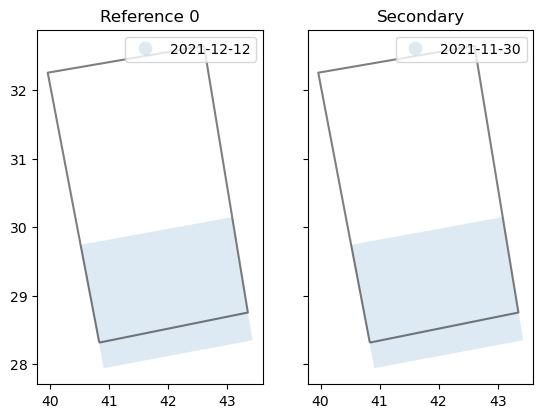

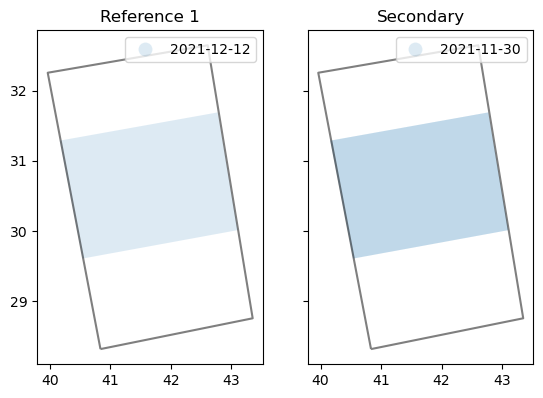

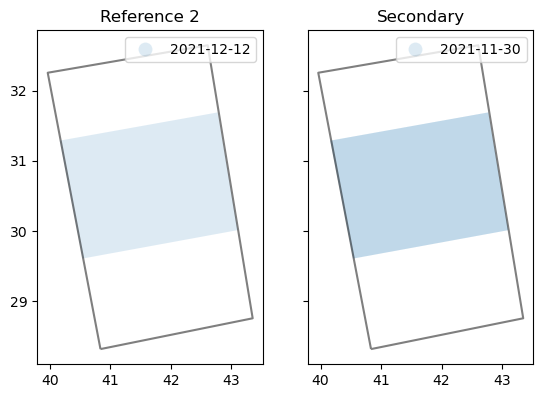

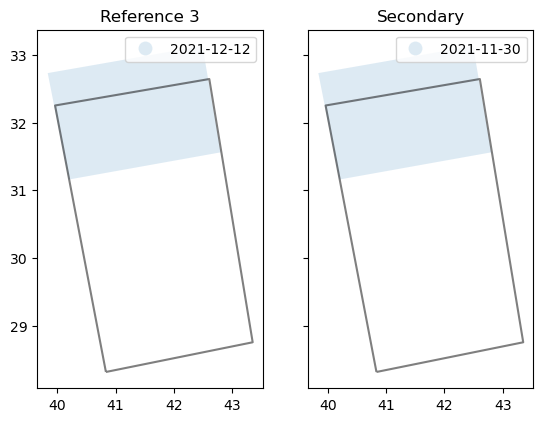

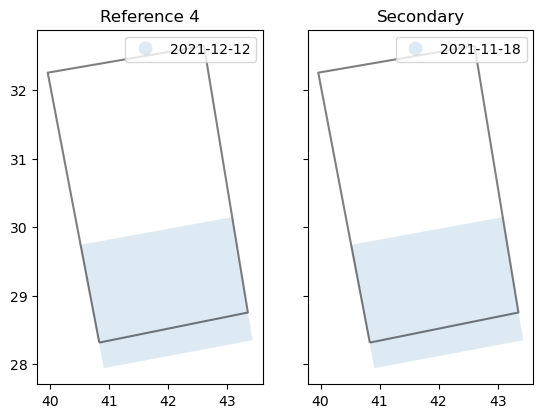

In [129]:
# Viewing GUNW pairs

# start index
M = 0
# number of pairs to view
N = 5

for J in range(M, M + N):
    pair = ifg_pairs[J]

    fig, axs = plt.subplots(1, 2, sharey=True, sharex=True)

    df_ref_plot = pair['reference']
    df_sec_plot = pair['secondary']

    df_ref_plot.plot(column='start_date_str', 
                     legend=True, 
                     ax=axs[0], alpha=.15)
    deploy_df.exterior.plot(ax=axs[0], alpha=.5, color='black')
    axs[0].set_title('Reference')

    df_sec_plot.plot(column='start_date_str', 
                     legend=True, 
                     ax=axs[1], alpha=.15)
    deploy_df.exterior.plot(ax=axs[1], alpha=.5, color='black')
    
    axs[0].set_title(f'Reference {J}')
    axs[1].set_title('Secondary')

# Visualize a Date Graph from Time Series

We can put this into a network Directed Graph and use some simple network functions to check connectivity.

We are going to use just dates for nodes, though you could use `(ref_date, hash_id)` for nodes and then inspect connected components. That is for another notebook.

Network connected:  True 


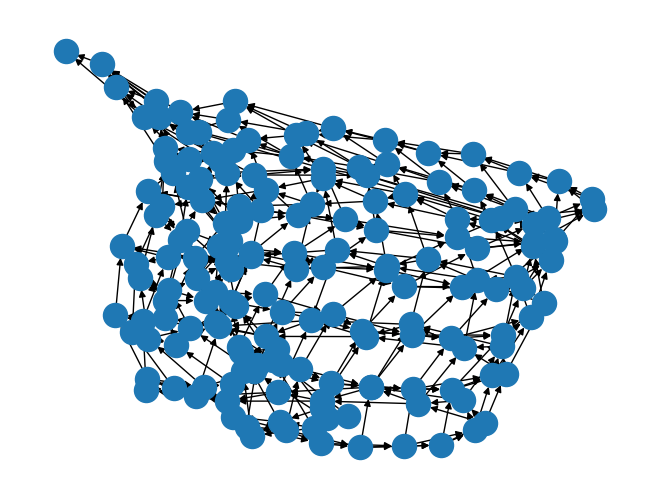

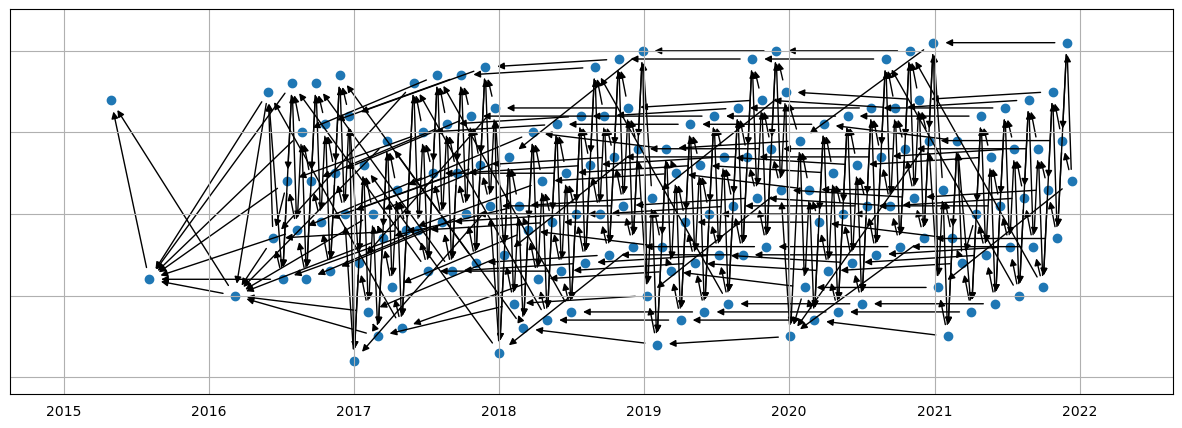

In [130]:
unique_dates = plot_network_graph(df_pairs)

# Deduplication Pt. 2

This is to ensure that previous processing hasn't generate any of the products we have just enumerated.


# Check CMR

This function checks the ASF DAAC if there are GUNWs with the same spatial extent and same date pairs as the ones created. At some point, we will be able to check the input SLC ids from CMR, but currently that is not possible.

If you are processing a new AOI whose products have not been delivered, you can ignore this step. It is a bit time consuming as the queries are done product by product.

In [131]:
from deploytools.cmr import get_cmr_products, capture_cmr_products 

# query CMR for all existing products in path
results = []
results = get_cmr_products(int(deploy_df.path_number))

# sort with descending product version numbers
results = sorted(results, key=lambda d: d['product_version'], reverse = True)

# convert CMR results to dataframe with the latest product version
new_results = []
track_scenes = []
for i in results:
    ifg_append = i['reference_scenes'] + i['secondary_scenes']
    # pass only first instance of scene combo
    if ifg_append not in track_scenes:
        track_scenes.append(ifg_append)
        new_results.append(i)

results = pd.DataFrame(new_results)
# update column names for merging
results.rename(columns={"reference_scenes": "reference", 
                        "secondary_scenes": "secondary"}, inplace = True)

# Finally filter out pairs in CMR
try:
    # parse all reference and secondary products for each corresponding product in CMR
    cmr_products = results['reference'] + results['secondary']
    cmr_products = cmr_products.to_list()
    # determine which products in the enumerator already exist in CMR
    df_pairs['product_id'] = df_pairs.apply(lambda r: capture_cmr_products(r, cmr_products), axis=1)
    # filter out pairs in CMR
    total_existing_gunws = len(df_pairs[df_pairs['product_id'].notna()])
    print('existing_gunws: ', total_existing_gunws)
    print('Total pairs', df_pairs.shape[0])
    df_pairs_filtered = df_pairs[~df_pairs['product_id'].notna()].reset_index(drop=True)
    df_pairs_filtered.drop_duplicates(subset=['hash_id'], inplace=True)
    print('after filtering, total pairs: ', df_pairs_filtered.shape[0])
except KeyError:
    df_pairs_filtered = copy.deepcopy(df_pairs)
    df_pairs_filtered.drop_duplicates(subset=['hash_id'], inplace=True)
    print('after filtering, total pairs: ', df_pairs_filtered.shape[0])
    
if len(df_pairs_filtered) == 0:
    raise Exception('All queried pairs are in CMR, there is nothing to process with specified parameters.')

existing_gunws:  12
Total pairs 1521
after filtering, total pairs:  1509


# Check Hyp3 Account

We are now going to check

1. check products in the open s3 bucket
2. check running/pending jobs

Notes:

1. Above, to accomplish step 1., there is some verbose code (see below). Once we automate delivery, this step will be obsolete. However, until we have delivery, we have to make sure that there are no existing products. Additionally, if we are using a separate (non-operational account), then would be good to use this.
2. If we are debugging products and some of our previously generated products were made incorrectly, we will want to ignore this step.

In [132]:
# uses .netrc; add `prompt=True` to prompt for credentials; 
hyp3_isce = hyp3_sdk.HyP3(DEPLOY_URL)
pending_jobs = hyp3_isce.find_jobs(status_code='PENDING') +  hyp3_isce.find_jobs(status_code='RUNNING')
all_jobs = hyp3_isce.find_jobs()
print(all_jobs)

37432 HyP3 Jobs: 23318 succeeded, 732 failed, 401 running, 12981 pending.


## 1. Get existing products in s3 bucket
Get bucket (there is only one)

In [133]:
from botocore import UNSIGNED
from botocore.config import Config
import boto3

job_data = [j.to_dict() for j in all_jobs]
job_data_s3 = list(filter(lambda job: 'files' in job.keys(), job_data))
# Only proceed if there are existing jobs
if job_data_s3 != []:
    bucket = job_data_s3[0]['files'][0]['s3']['bucket']
    print(f'Before checking with s3, #: {df_pairs_filtered.shape[0]}')
    # Get all keys
    job_keys = [job['files'][0]['s3']['key'] for job in job_data_s3]

    s3 = boto3.resource('s3',config=Config(signature_version=UNSIGNED))
    prod_bucket = s3.Bucket(bucket)

    objects = list(prod_bucket.objects.all())
    ncs = list(filter(lambda x: x.key.endswith('.nc'), objects))

    # Need to physically check if the products are not there (could have been deleted!)

    nc_keys = [nc_ob.key for nc_ob in ncs]
    jobs_with_prods_in_s3 = [job for (k, job) in enumerate(job_data_s3) if job_keys[k] in nc_keys]

    slcs = [(job['job_parameters']['granules'],
            job['job_parameters']['secondary_granules']) 
            for job in jobs_with_prods_in_s3]

    hash_ids_of_prods_in_s3 = [get_gunw_hash_id(*slc) for slc in slcs]

    print(f"We are removing {df_pairs_filtered['hash_id'].isin(hash_ids_of_prods_in_s3).sum()} GUNWs for submission")

    items = hash_ids_of_prods_in_s3
    df_pairs_filtered = df_pairs_filtered[~df_pairs_filtered['hash_id'].isin(items)].reset_index(drop=True)
    print(f"Current # of GUNWs: {df_pairs_filtered.shape[0]}")

Before checking with s3, #: 1509
We are removing 0 GUNWs for submission
Current # of GUNWs: 1509


## 2. Running or Pending Jobs

In [134]:
# Only proceed if there are existing jobs
if job_data_s3 != []:
    pending_job_data = [j.to_dict() for j in pending_jobs]
    pending_slcs = [(job['job_parameters']['granules'],
                    job['job_parameters']['secondary_granules']) 
                    for job in pending_job_data]

    hash_ids_of_pending_jobs = [get_gunw_hash_id(*slc) for slc in pending_slcs]

    items = hash_ids_of_pending_jobs
    print(f"We are removing {df_pairs_filtered['hash_id'].isin(items).sum()} GUNWs for submission")

    items = hash_ids_of_pending_jobs
    df_pairs_filtered = df_pairs_filtered[~df_pairs_filtered['hash_id'].isin(items)].reset_index(drop=True)
    print(f"Current # of GUNWs: {df_pairs_filtered.shape[0]}")

We are removing 422 GUNWs for submission
Current # of GUNWs: 1087


# Visualize a Date Graph from the Final Filtered Time Series

We can put this into a network Directed Graph and use some simple network functions to check connectivity (*which may not be applicable).

We are going to use just dates for nodes, though you could use `(ref_date, hash_id)` for nodes and then inspect connected components. That is for another notebook.

Network connected:  True 


"\nThis function checks there is a path from the first date to the last one. The y-axis is created purely for display so doesn't really indicated anything but flow by month.\n\n*Again, this may not be applicable in cases where parts of the network had already been deployed before and/or you are densifying by specifying temporal sampling.\nIn such cases, these plots serve merely as a sanity check.\n"

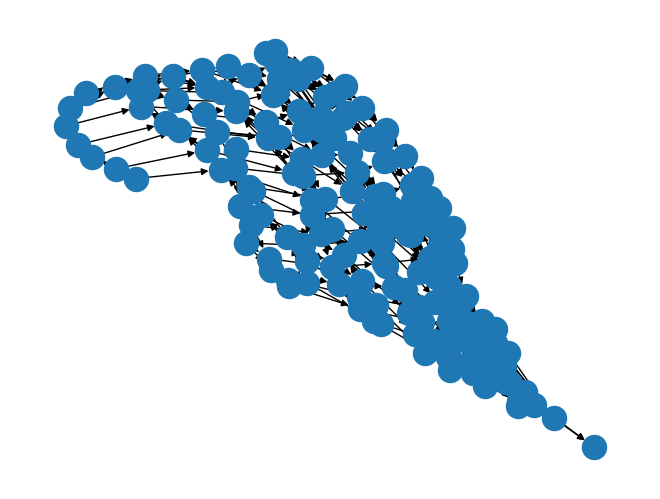

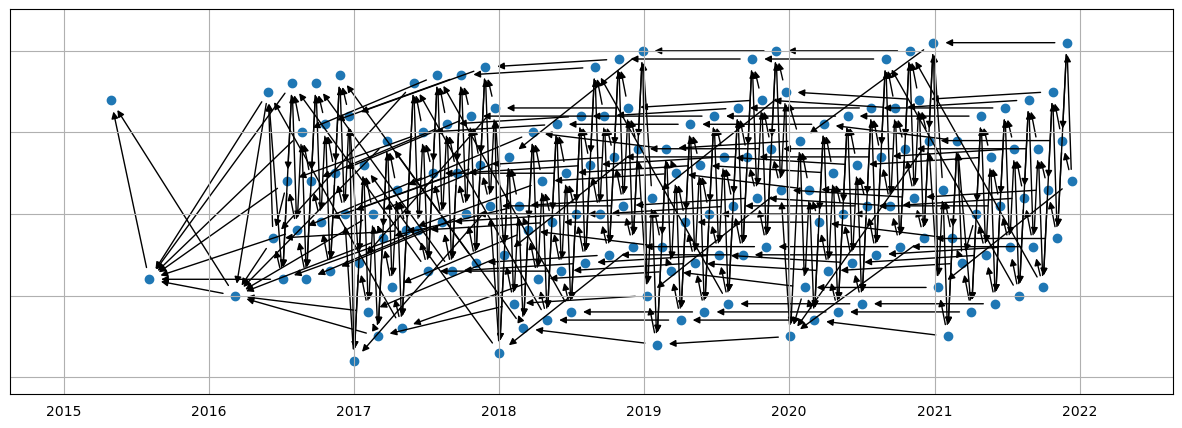

In [135]:
unique_dates = plot_network_graph(df_pairs_filtered)

'''
This function checks there is a path from the first date to the last one. The y-axis is created purely for display so doesn't really indicated anything but flow by month.

*Again, this may not be applicable in cases where parts of the network had already been deployed before and/or you are densifying by specifying temporal sampling.
In such cases, these plots serve merely as a sanity check.
'''


# Submit jobs to Hyp3

In [137]:
records_to_submit = df_pairs_filtered.to_dict('records')
records_to_submit[0]

{'reference': ['S1B_IW_SLC__1SDV_20211212T151510_20211212T151538_029994_0394B3_C020'],
 'secondary': ['S1B_IW_SLC__1SDV_20211130T151511_20211130T151539_029819_038F31_9BE1',
  'S1B_IW_SLC__1SDV_20211130T151511_20211130T151539_029819_038F31_9BE1'],
 'reference_date': Timestamp('2021-12-12 00:00:00'),
 'secondary_date': Timestamp('2021-11-30 00:00:00'),
 'path_number': 43,
 'geometry': <shapely.geometry.polygon.Polygon at 0x1aeba69d0>,
 'hash_id': '1a06ff88786d3716fe46eee4918f09d7',
 'product_id': nan}

The below puts the records in a format that we can submit to the Hyp3 API.

**Note 1**: there is an index in the records to submit to ensure we don't over submit jobs for generating GUNWs. \
**Note 2**: uncomment the code to *actually* submit the jobs.

In [138]:
# uses .netrc; add `prompt=True` to prompt for credentials; 
hyp3_isce = hyp3_sdk.HyP3(DEPLOY_URL)

# NOTE: we are using "INSAR_ISCE" for the `main` branch.
# Change this to "INSAR_ISCE_TEST" to use the `dev` branch, but ONLY if you know what you're doing
# chaging to dev will overwrite the product version number and make it difficult to dedup
job_type = 'INSAR_ISCE'

job_dicts = [{'name': deploy_df.job_name[0].capitalize(),
              'job_type': job_type,
              'job_parameters': {'granules': r['reference'],
                                 'secondary_granules': r['secondary']}} 
             # NOTE THERE IS AN INDEX - this is to submit only a subset of Jobs
             for r in records_to_submit]

# Report summary of all job parameters
print("Start date is '{}'".format(unique_dates[0]))
print("End date is '{}'".format(unique_dates[-1]))
print("GUNWs expected '{}'".format(len(job_dicts)))
print("Job Name is '{}'".format(deploy_df.job_name[0].capitalize()))
print("Shapefile Name is '{}'".format(track_filename.name))
print('##########################################')
print('Existing HyP3 jobs:')
jobs = hyp3_isce.find_jobs()
print(jobs)
print(f'\nExisting HyP3 jobs for {deploy_df.job_name[0].capitalize()}:')
jobs = hyp3_isce.find_jobs(name=deploy_df.job_name[0].capitalize())
print(jobs)

Start date is '2015-04-30 00:00:00'
End date is '2021-12-12 00:00:00'
GUNWs expected '1087'
Job Name is 'Arabian_43'
Shapefile Name is 'ArabiaN_pathNumber43.geojson'
##########################################
Existing HyP3 jobs:
37432 HyP3 Jobs: 23318 succeeded, 732 failed, 401 running, 12981 pending.

Existing HyP3 jobs for Arabian_43:
0 HyP3 Jobs: 0 succeeded, 0 failed, 0 running, 0 pending.


In [ ]:
SUBMIT = False

if SUBMIT:
    #UNCOMMENT TO SUBMIT
    prepared_jobs = job_dicts
    submitted_jobs = hyp3_sdk.Batch()
    for batch in hyp3_sdk.util.chunk(prepared_jobs):
        submitted_jobs += hyp3_isce.submit_prepared_jobs(batch)